In [26]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import sys
sys.path.append('/Users/sebastianjara/Documents/Reu jueves uv/18_Julio_v2/')
from Core.data_selector import DataSelector

import matplotlib.pyplot as plt
import random

In [3]:
# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 1. Data set MNIST

In [4]:
# Load data
(X_train, y_train), (X_val, y_val) = mnist.load_data()

# Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_plot=X_train
y_plot=y_train
#Flatten the images to make them one-dimensional vectors
X_train = X_train[..., tf.newaxis]
X_val = X_val[..., tf.newaxis]

# Encode the labels using OneHotEncoder
enc = OneHotEncoder(sparse_output=False)
y_train_encoded = enc.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = enc.transform(y_val.reshape(-1, 1))

# Selection of training and validation data
num_samples_train = 10000
num_samples_val = int(num_samples_train / 6)

# Generate random indices for the training set
random_indices_train = np.random.choice(len(X_train), size= num_samples_train, replace=False)

# Generate random indices for the validation set
random_indices_val = np.random.choice(len(X_val), size=num_samples_val, replace=False)

X_train = X_train[random_indices_train]
y_train_encoded = y_train_encoded[random_indices_train]
X_plot=X_plot[random_indices_train]
y_plot=y_plot[random_indices_train]
X_val = X_val[random_indices_val]
y_val_encoded = y_val_encoded[random_indices_val]

print(f'Size training set: {X_train.shape}')
print(f'Size Val set: {X_val.shape}')
print(f'Size training labels: {y_train_encoded.shape}')
print(f'Size Val labels: {y_val_encoded.shape}')

Size training set: (10000, 28, 28, 1)
Size Val set: (1666, 28, 28, 1)
Size training labels: (10000, 10)
Size Val labels: (1666, 10)


## 2. Model

In [5]:
# Create the model
class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
        self.maxpool_1 = tf.keras.layers.MaxPooling2D((2, 2))#
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.maxpool_2 = tf.keras.layers.MaxPooling2D((2, 2))#
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool_1(x)
        x = self.conv2(x)
        x = self.maxpool_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def inspector_out(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool_1(x)
        x = self.conv2(x)
        x = self.maxpool_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [7]:
# Instantiate the model
model_mnist = CustomModel()

## 3. First training phase: without filtering

In [8]:
# Training configuration
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_mnist.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy',      
                               patience=20,                
                               verbose=1,                   
                               mode='max',                  
                               restore_best_weights=True)  

In [9]:
# Training
model_mnist.fit(X_train, y_train_encoded, epochs=3000, batch_size=3000, verbose = 0, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

2024-07-18 09:01:20.899228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-18 09:01:23.749331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 55.
Epoch 75: early stopping


### Results

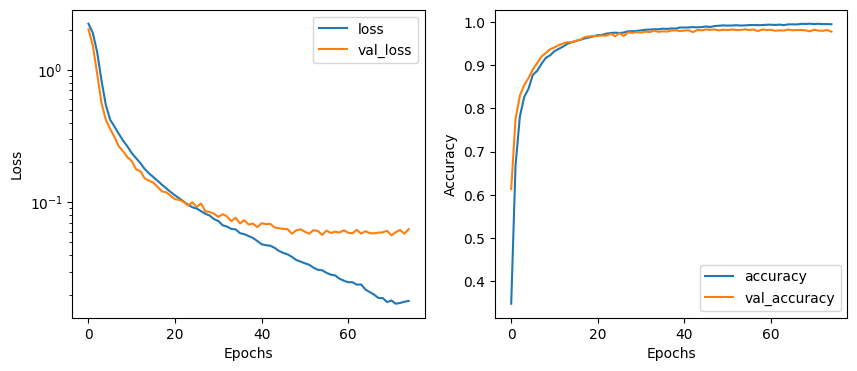

In [10]:
# Loss function graph and accuracy graph
plt.figure(figsize=(10, 4))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(model_mnist.history.history['loss'], label='loss')
plt.plot(model_mnist.history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Accuracy graph 
plt.subplot(1, 2, 2)
plt.plot(model_mnist.history.history['accuracy'], label='accuracy')
plt.plot(model_mnist.history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [11]:
# Evaluation for the best weights for the model
loss_train, accuracy_train = model_mnist.evaluate(X_train, y_train_encoded, verbose=0)
loss_val, accuracy_val = model_mnist.evaluate(X_val, y_val_encoded, verbose=0)
print(f"Train loss: {loss_train}")
print(f"Train accuracy: {accuracy_train}")
print(f"Validation loss: {loss_val}")
print(f"Validation accuracy: {accuracy_val}")

Train loss: 0.02915465459227562
Train accuracy: 0.9930999875068665
Validation loss: 0.05680937319993973
Validation accuracy: 0.9831932783126831


## 4. Second training phase: with filtering

In [12]:
epochs = 20                    # Number of epochs
epoch_init_filter = 1          # Epoch at which the filter starts
update_period_in_epochs = 5    # Update period in epochs

In [13]:
# Instantiate data selector
data_selector = DataSelector(X_train, y_train_encoded, epoch_init_filter , update_period_in_epochs, filter_percentile=0.25, random_state=280296, train_with_outliers=False)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Set up the callback to save the best weights
checkpoint_filepath = 'model_checkpoint.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=0)

In [15]:
# Dictionary to store the training information
train_info = {
    'train_losses': [],
    'val_losses': [],
    'train_accuracies': [],
    'val_accuracies': []
}

In [16]:
# Training loop
for epoch in range(epochs):
    # Get filtered training sets
    X_tr_filtered, y_tr_filtered, _, data_removed = data_selector.get_train_data(epoch=epoch, model=model_mnist, outs_posibilities=list(np.unique(y_train)), explained_variance = 0.95)
    
    # Fit the model
    history = model_mnist.fit(X_tr_filtered, y_tr_filtered, epochs=1, batch_size=3000, verbose=0, validation_data=(X_val, y_val_encoded), callbacks=[model_checkpoint_callback] )
    
    # Store the training information
    train_info['train_losses'].append(history.history['loss'])
    train_info['val_losses'].append(history.history['val_loss'])
    train_info['train_accuracies'].append(history.history['accuracy'])
    train_info['val_accuracies'].append(history.history['val_accuracy'])

    print(f"Epoch: {epoch+1}")

Epoch: 1
PCA done: retained 95.0% of the variance with 14 components
PCA done with 14 components
Size of the training set: 10000
All classes have just one cluster associated
Number of probabilities below the threshold 1.0 for the actual class 0:  46
Number of probabilities below the threshold 1.0 for the actual class 1:  130
Number of probabilities below the threshold 1.0 for the actual class 2:  54
Number of probabilities below the threshold 1.0 for the actual class 3:  62
Number of probabilities below the threshold 1.0 for the actual class 4:  175
Number of probabilities below the threshold 1.0 for the actual class 5:  53
Number of probabilities below the threshold 1.0 for the actual class 6:  78
Number of probabilities below the threshold 1.0 for the actual class 7:  198
Number of probabilities below the threshold 1.0 for the actual class 8:  52
Number of probabilities below the threshold 1.0 for the actual class 9:  105
Remove data: [6144 4098 2053 8197 2055   10 2060   17 8209 411

In [17]:
print(f'Initial sets training: {X_train.shape[0]}')
print(f'Final sets training: {X_tr_filtered.shape[0]}')


Initial sets training: 10000
Final sets training: 9017


### Results

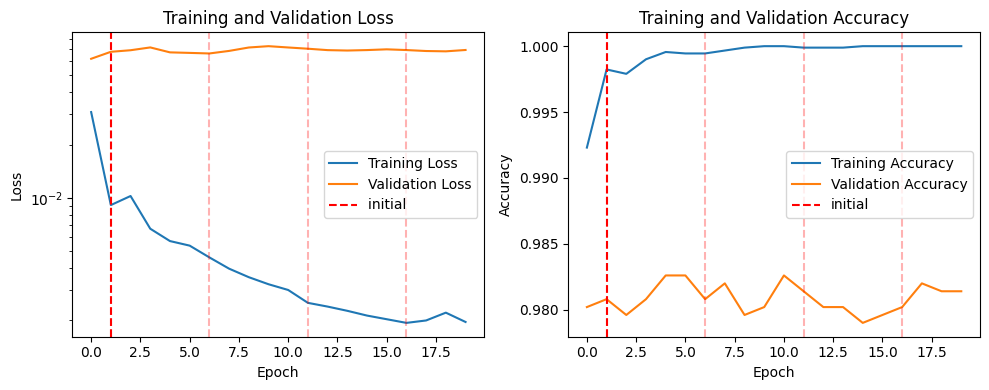

In [18]:
# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_info['train_losses'], label='Training Loss')
plt.plot(train_info['val_losses'], label='Validation Loss')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='initial ')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_info['train_accuracies'], label='Training Accuracy')
plt.plot(train_info['val_accuracies'], label='Validation Accuracy')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='initial')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  # Líneas cada 5 epochs
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Load best weights
model_mnist.load_weights(checkpoint_filepath)

# Evaluation Accuracy
loss_train, accuracy_train = model_mnist.evaluate(X_tr_filtered, y_tr_filtered, verbose=0)
loss_val, accuracy_val = model_mnist.evaluate(X_val, y_val_encoded, verbose=0)
print(f"Training loss: {loss_train}")
print(f"Training accuracy: {accuracy_train}")
print(f"Validation loss: {loss_val}")
print(f"Validation accuracy: {accuracy_val}")



Training loss: 0.004933381453156471
Training accuracy: 0.9994454979896545
Validation loss: 0.06735881417989731
Validation accuracy: 0.9825930595397949


## 5. Outliers Visualization

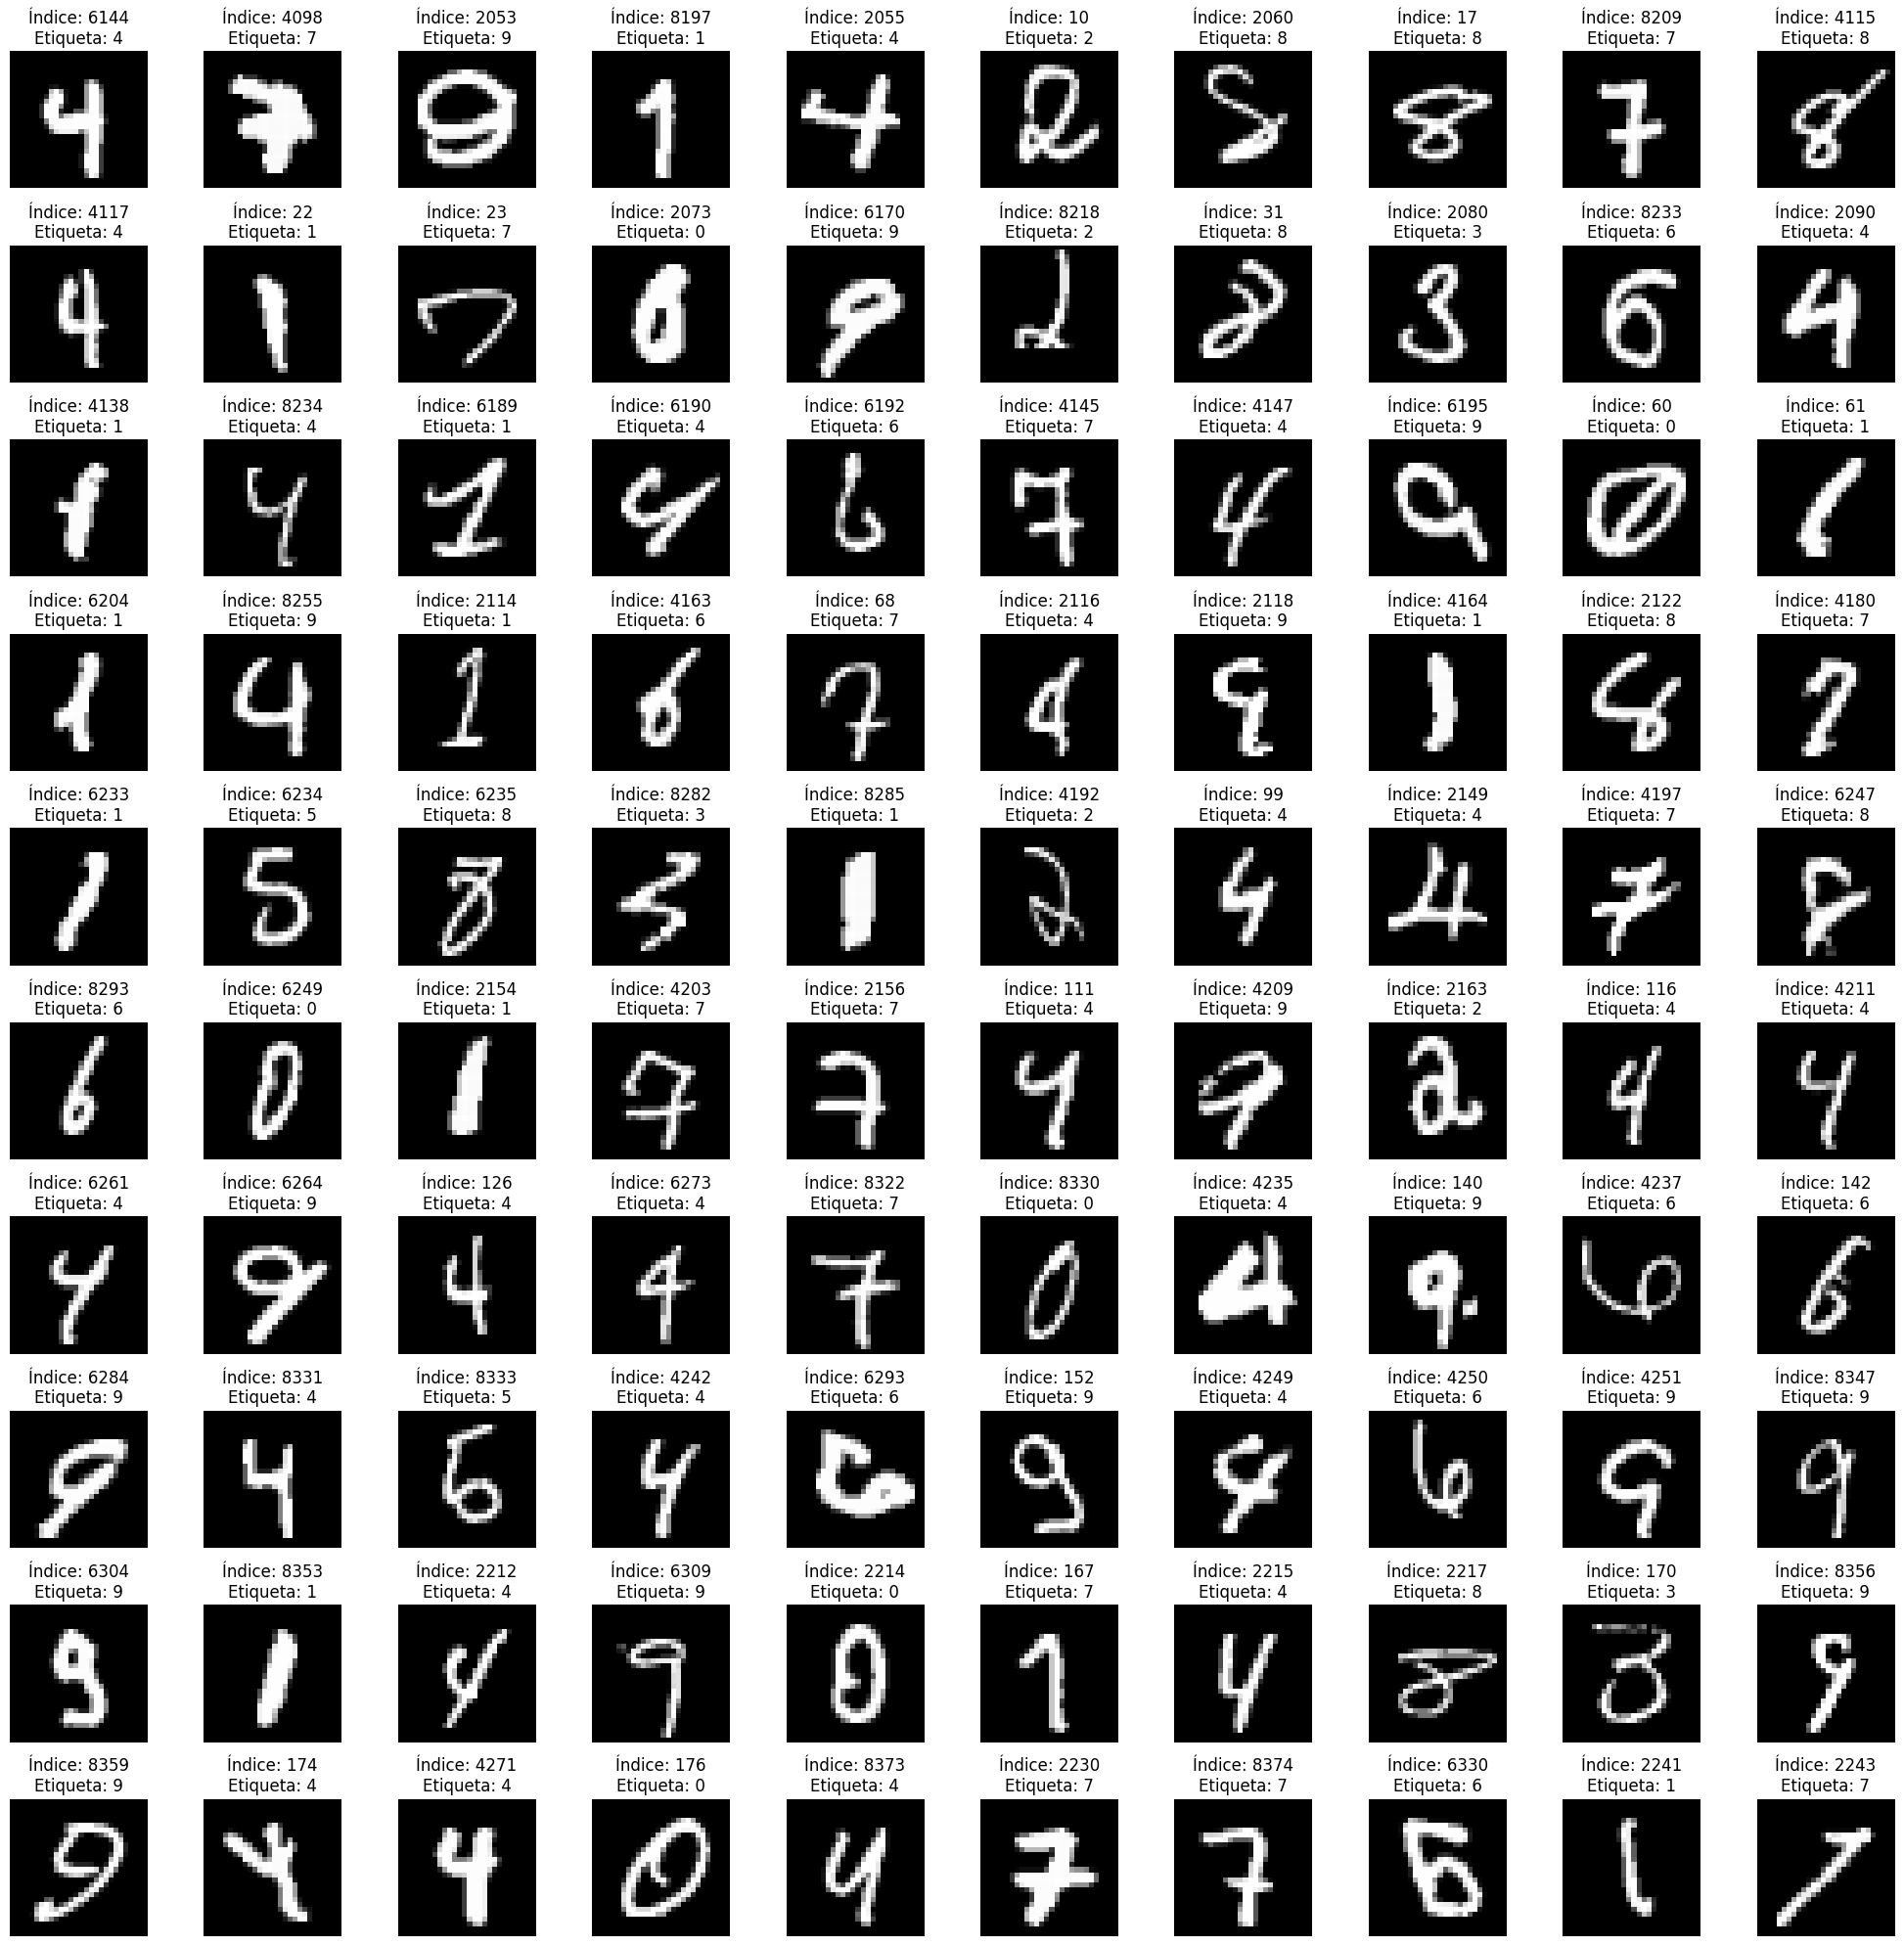

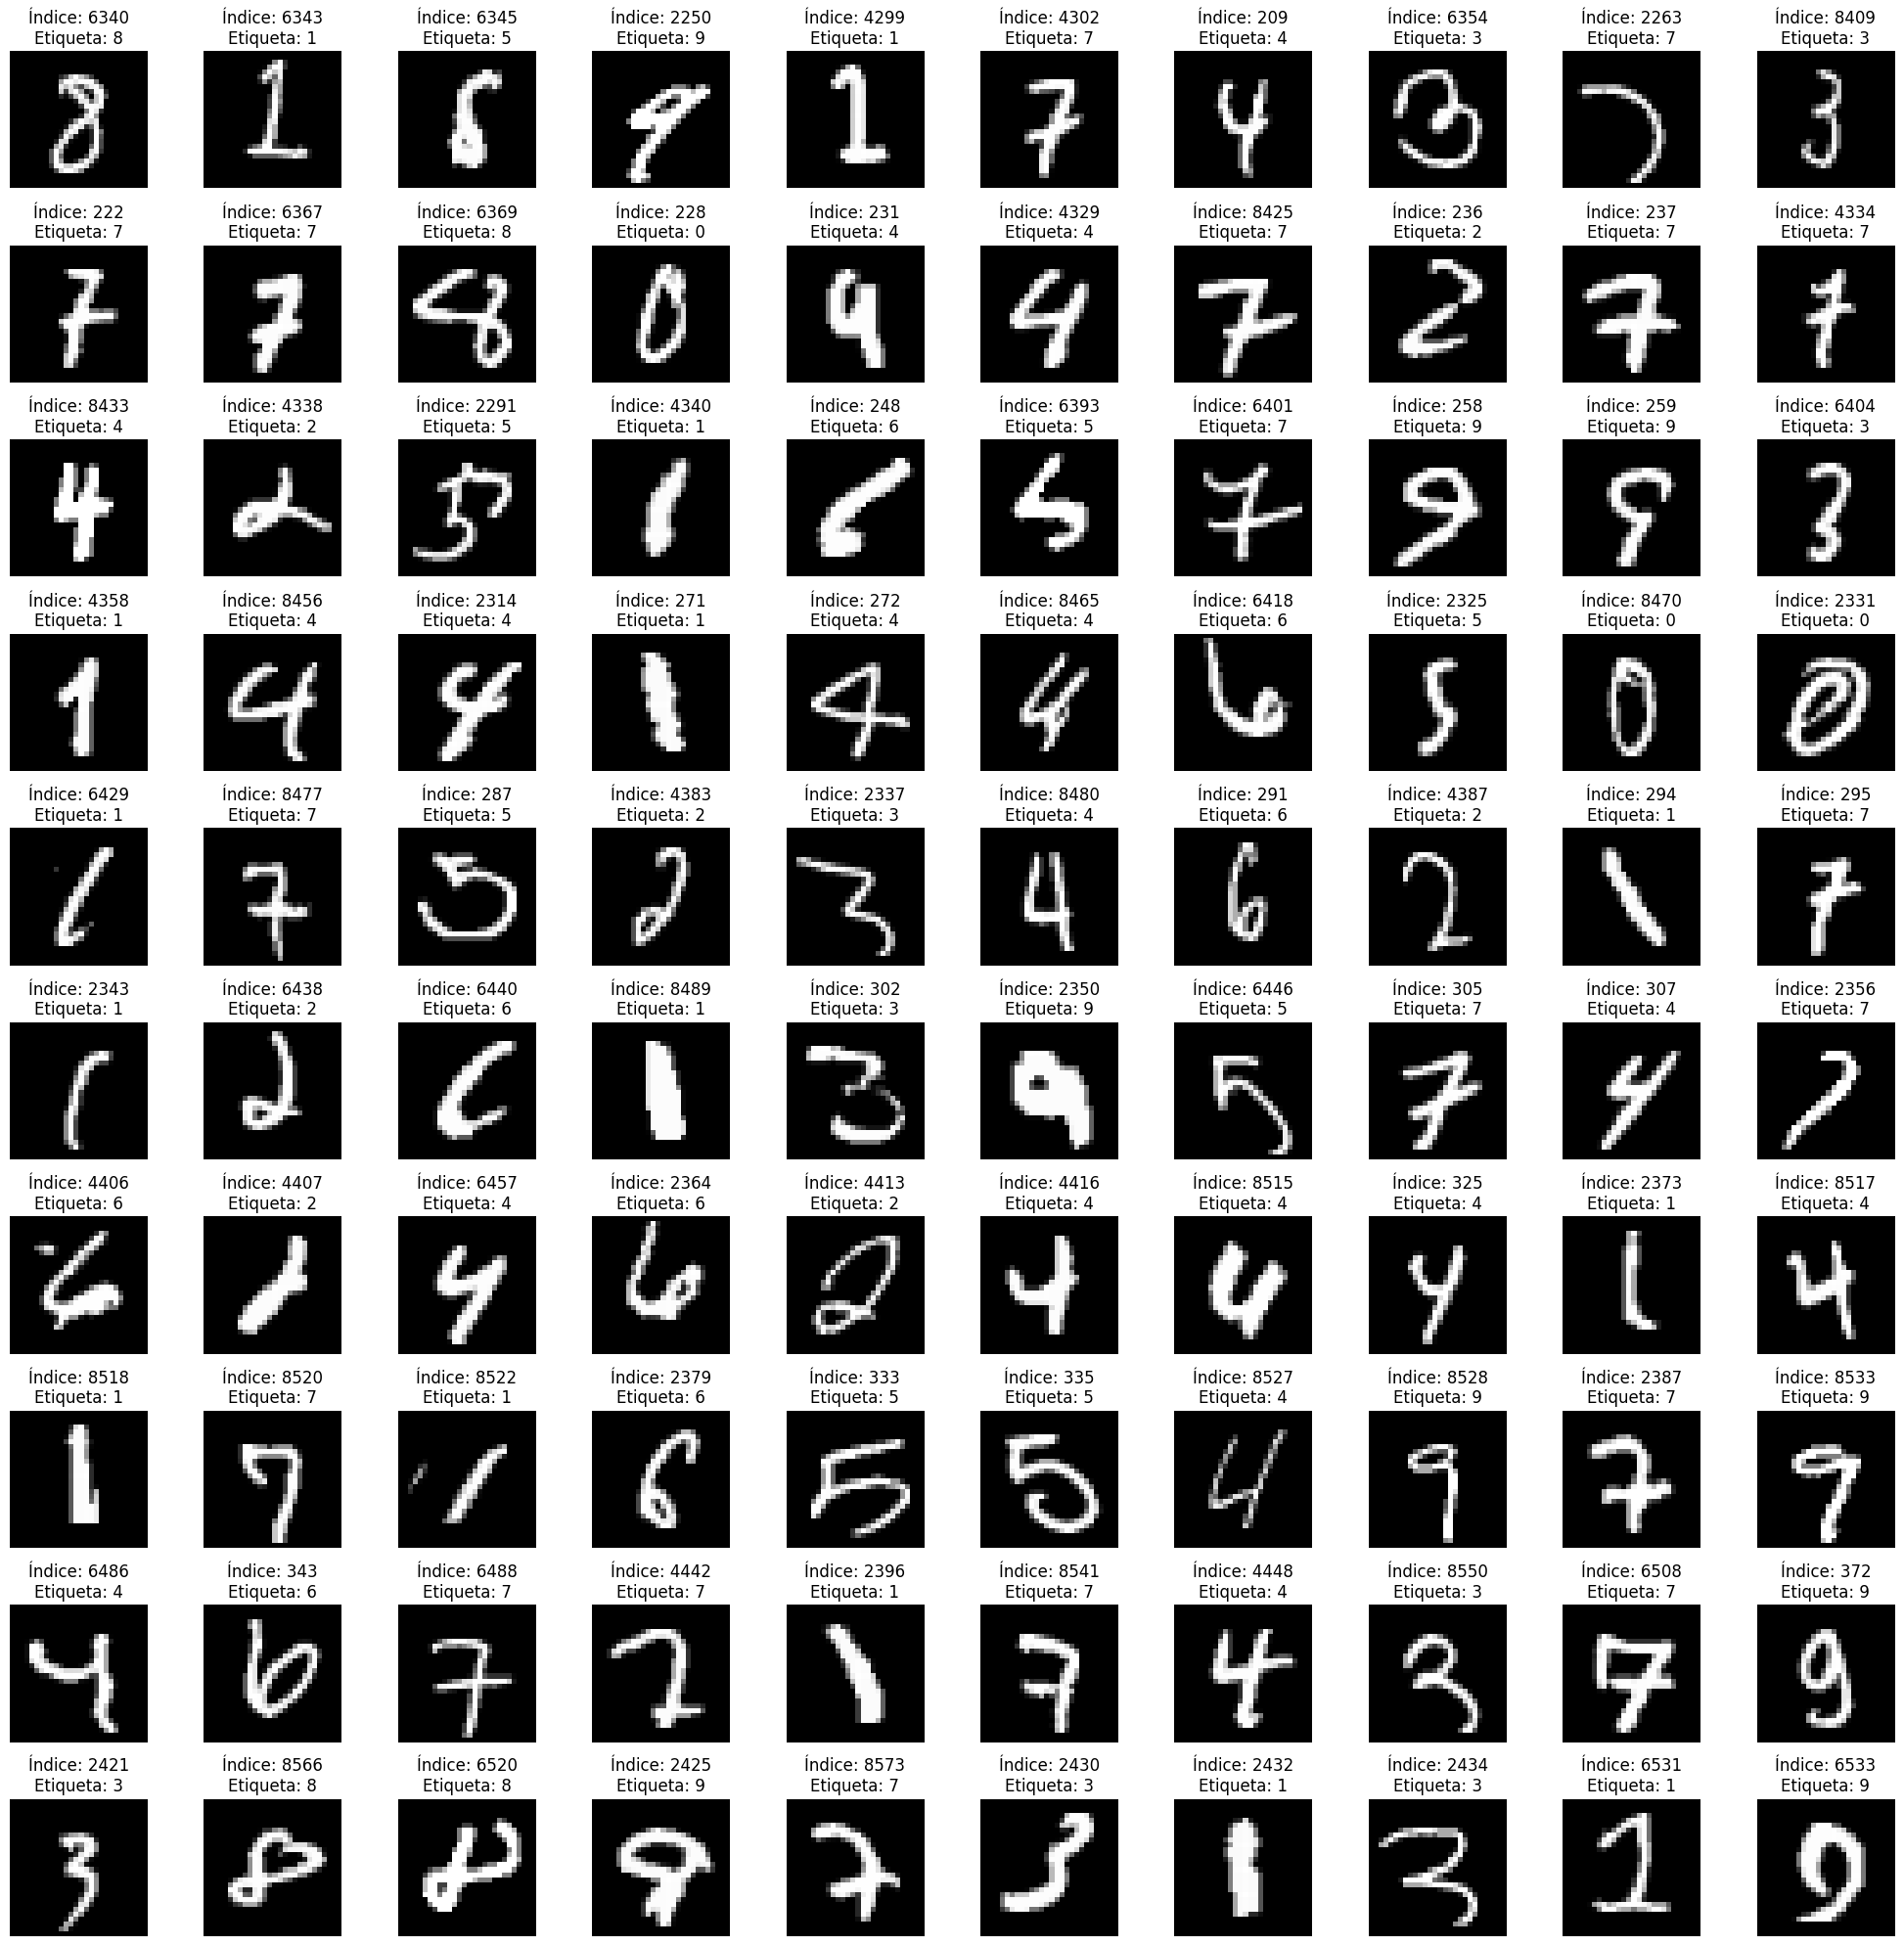

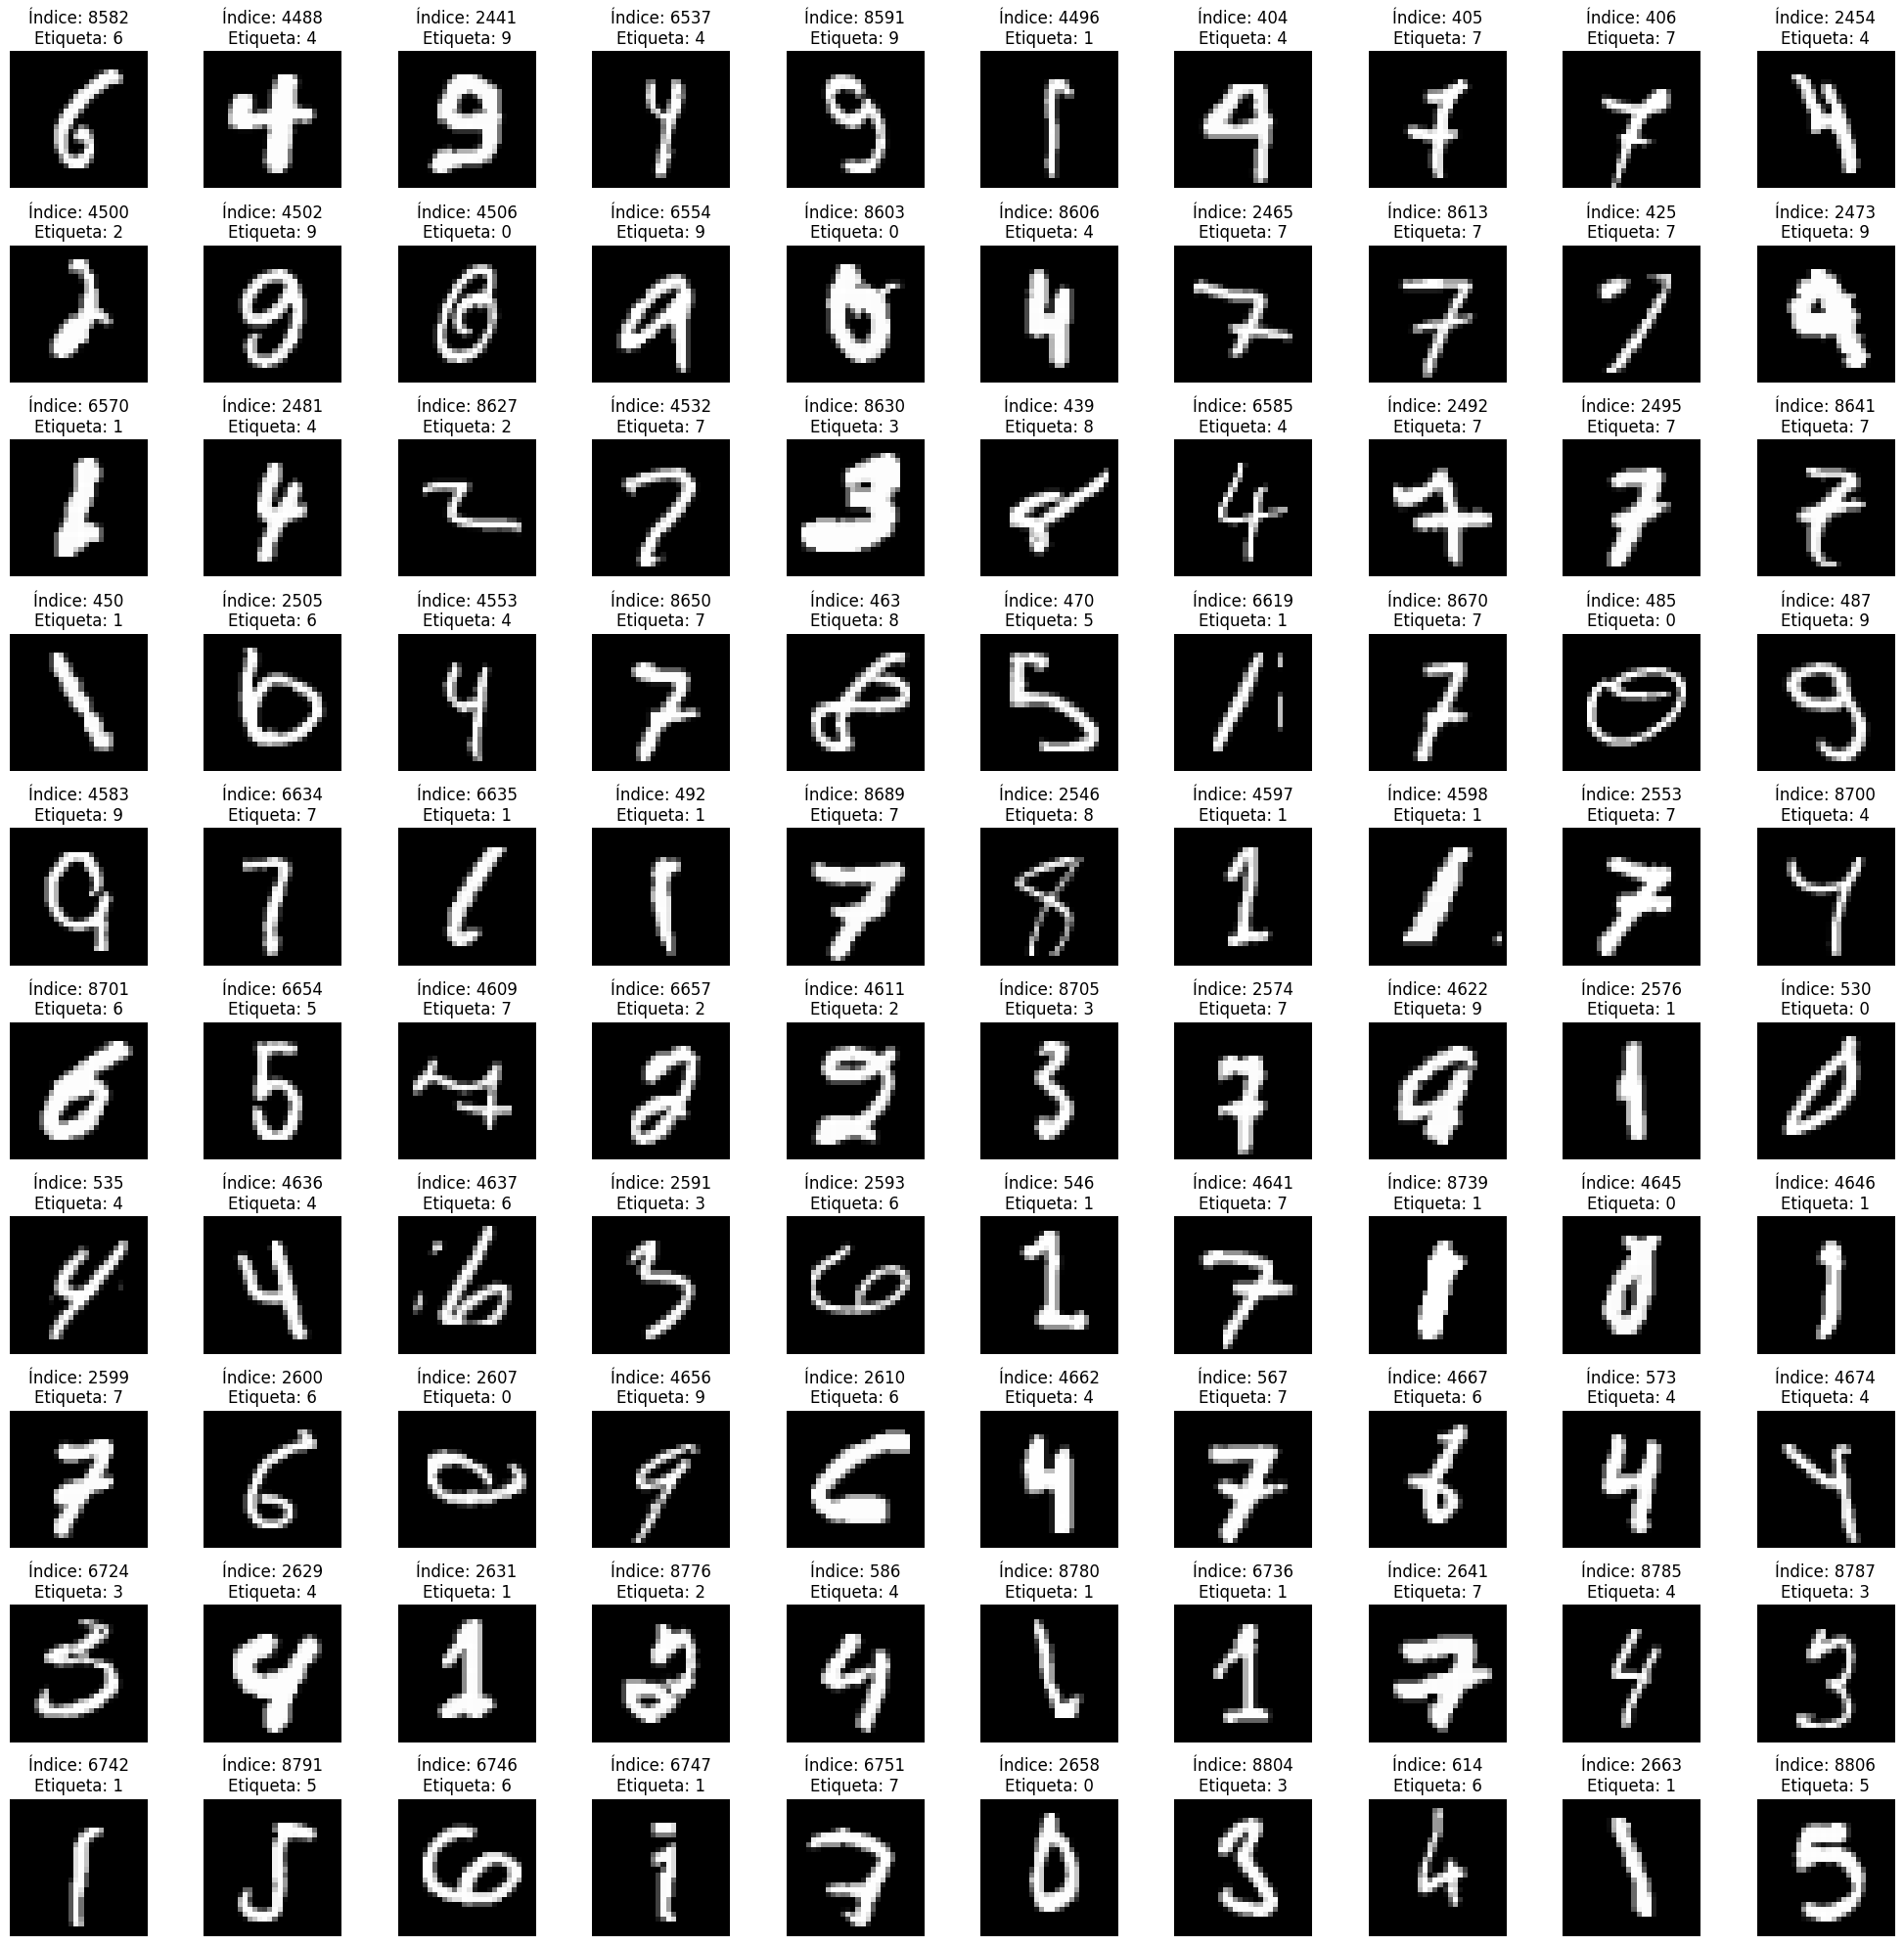

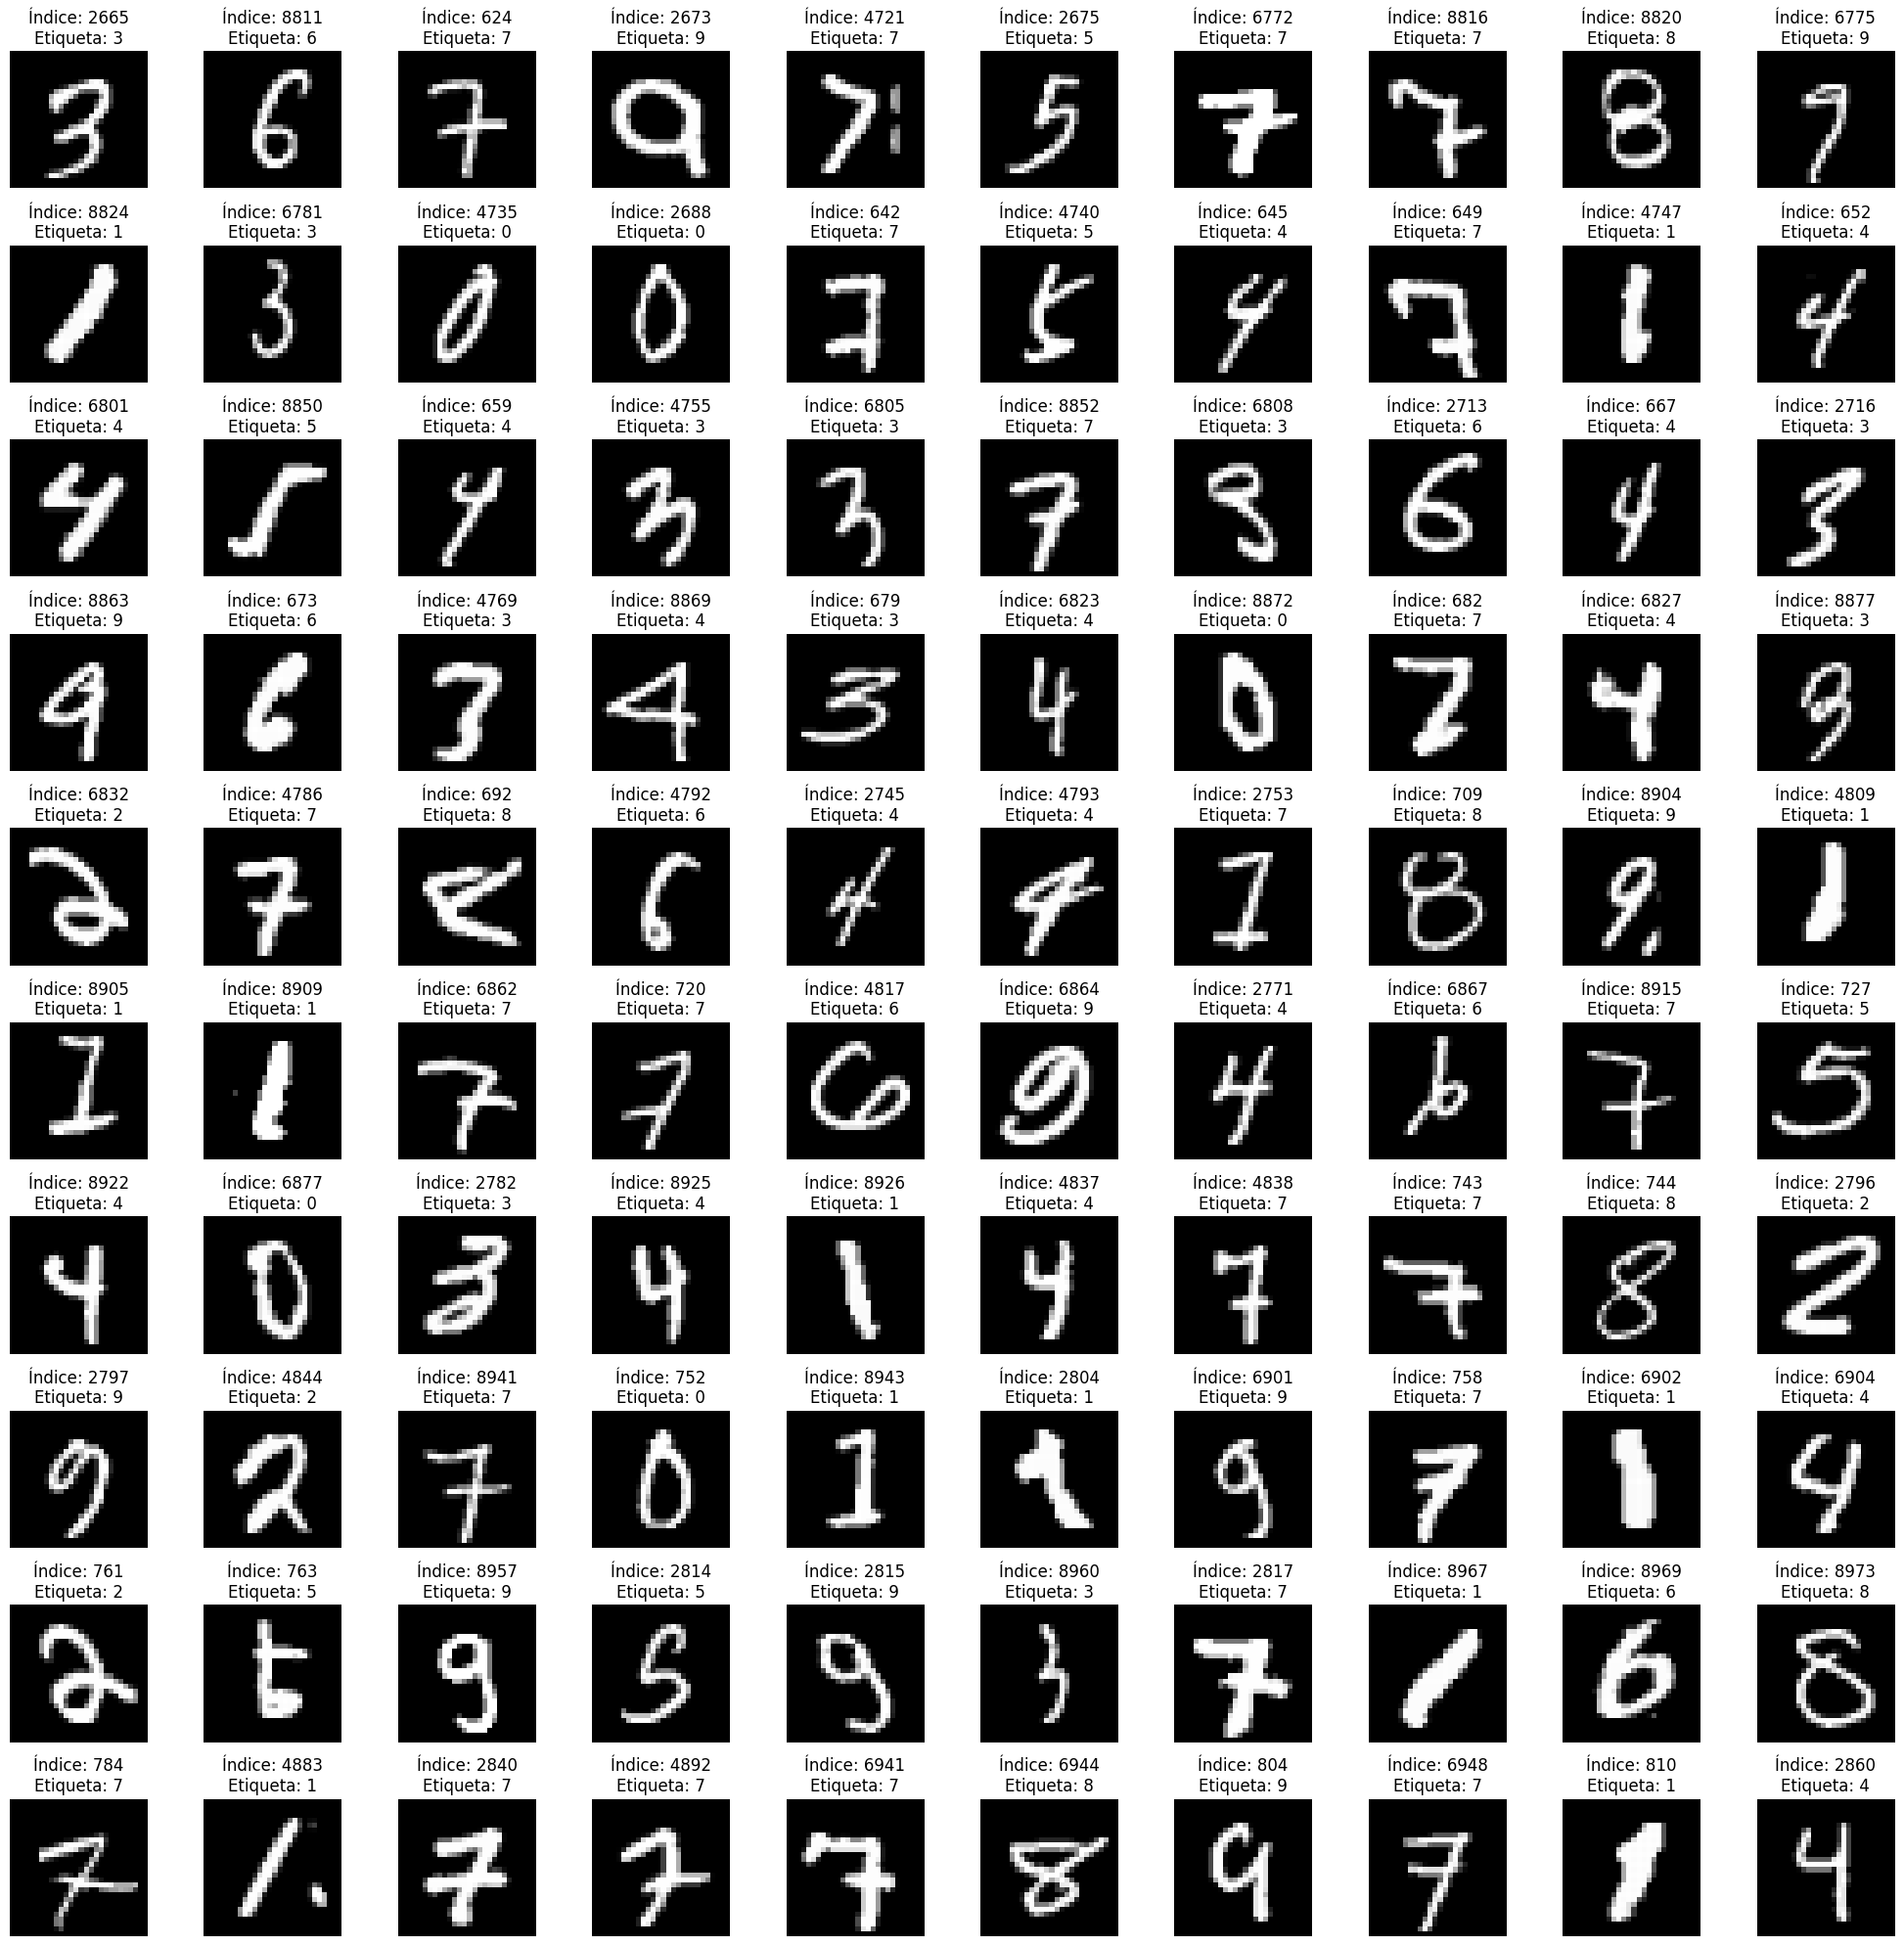

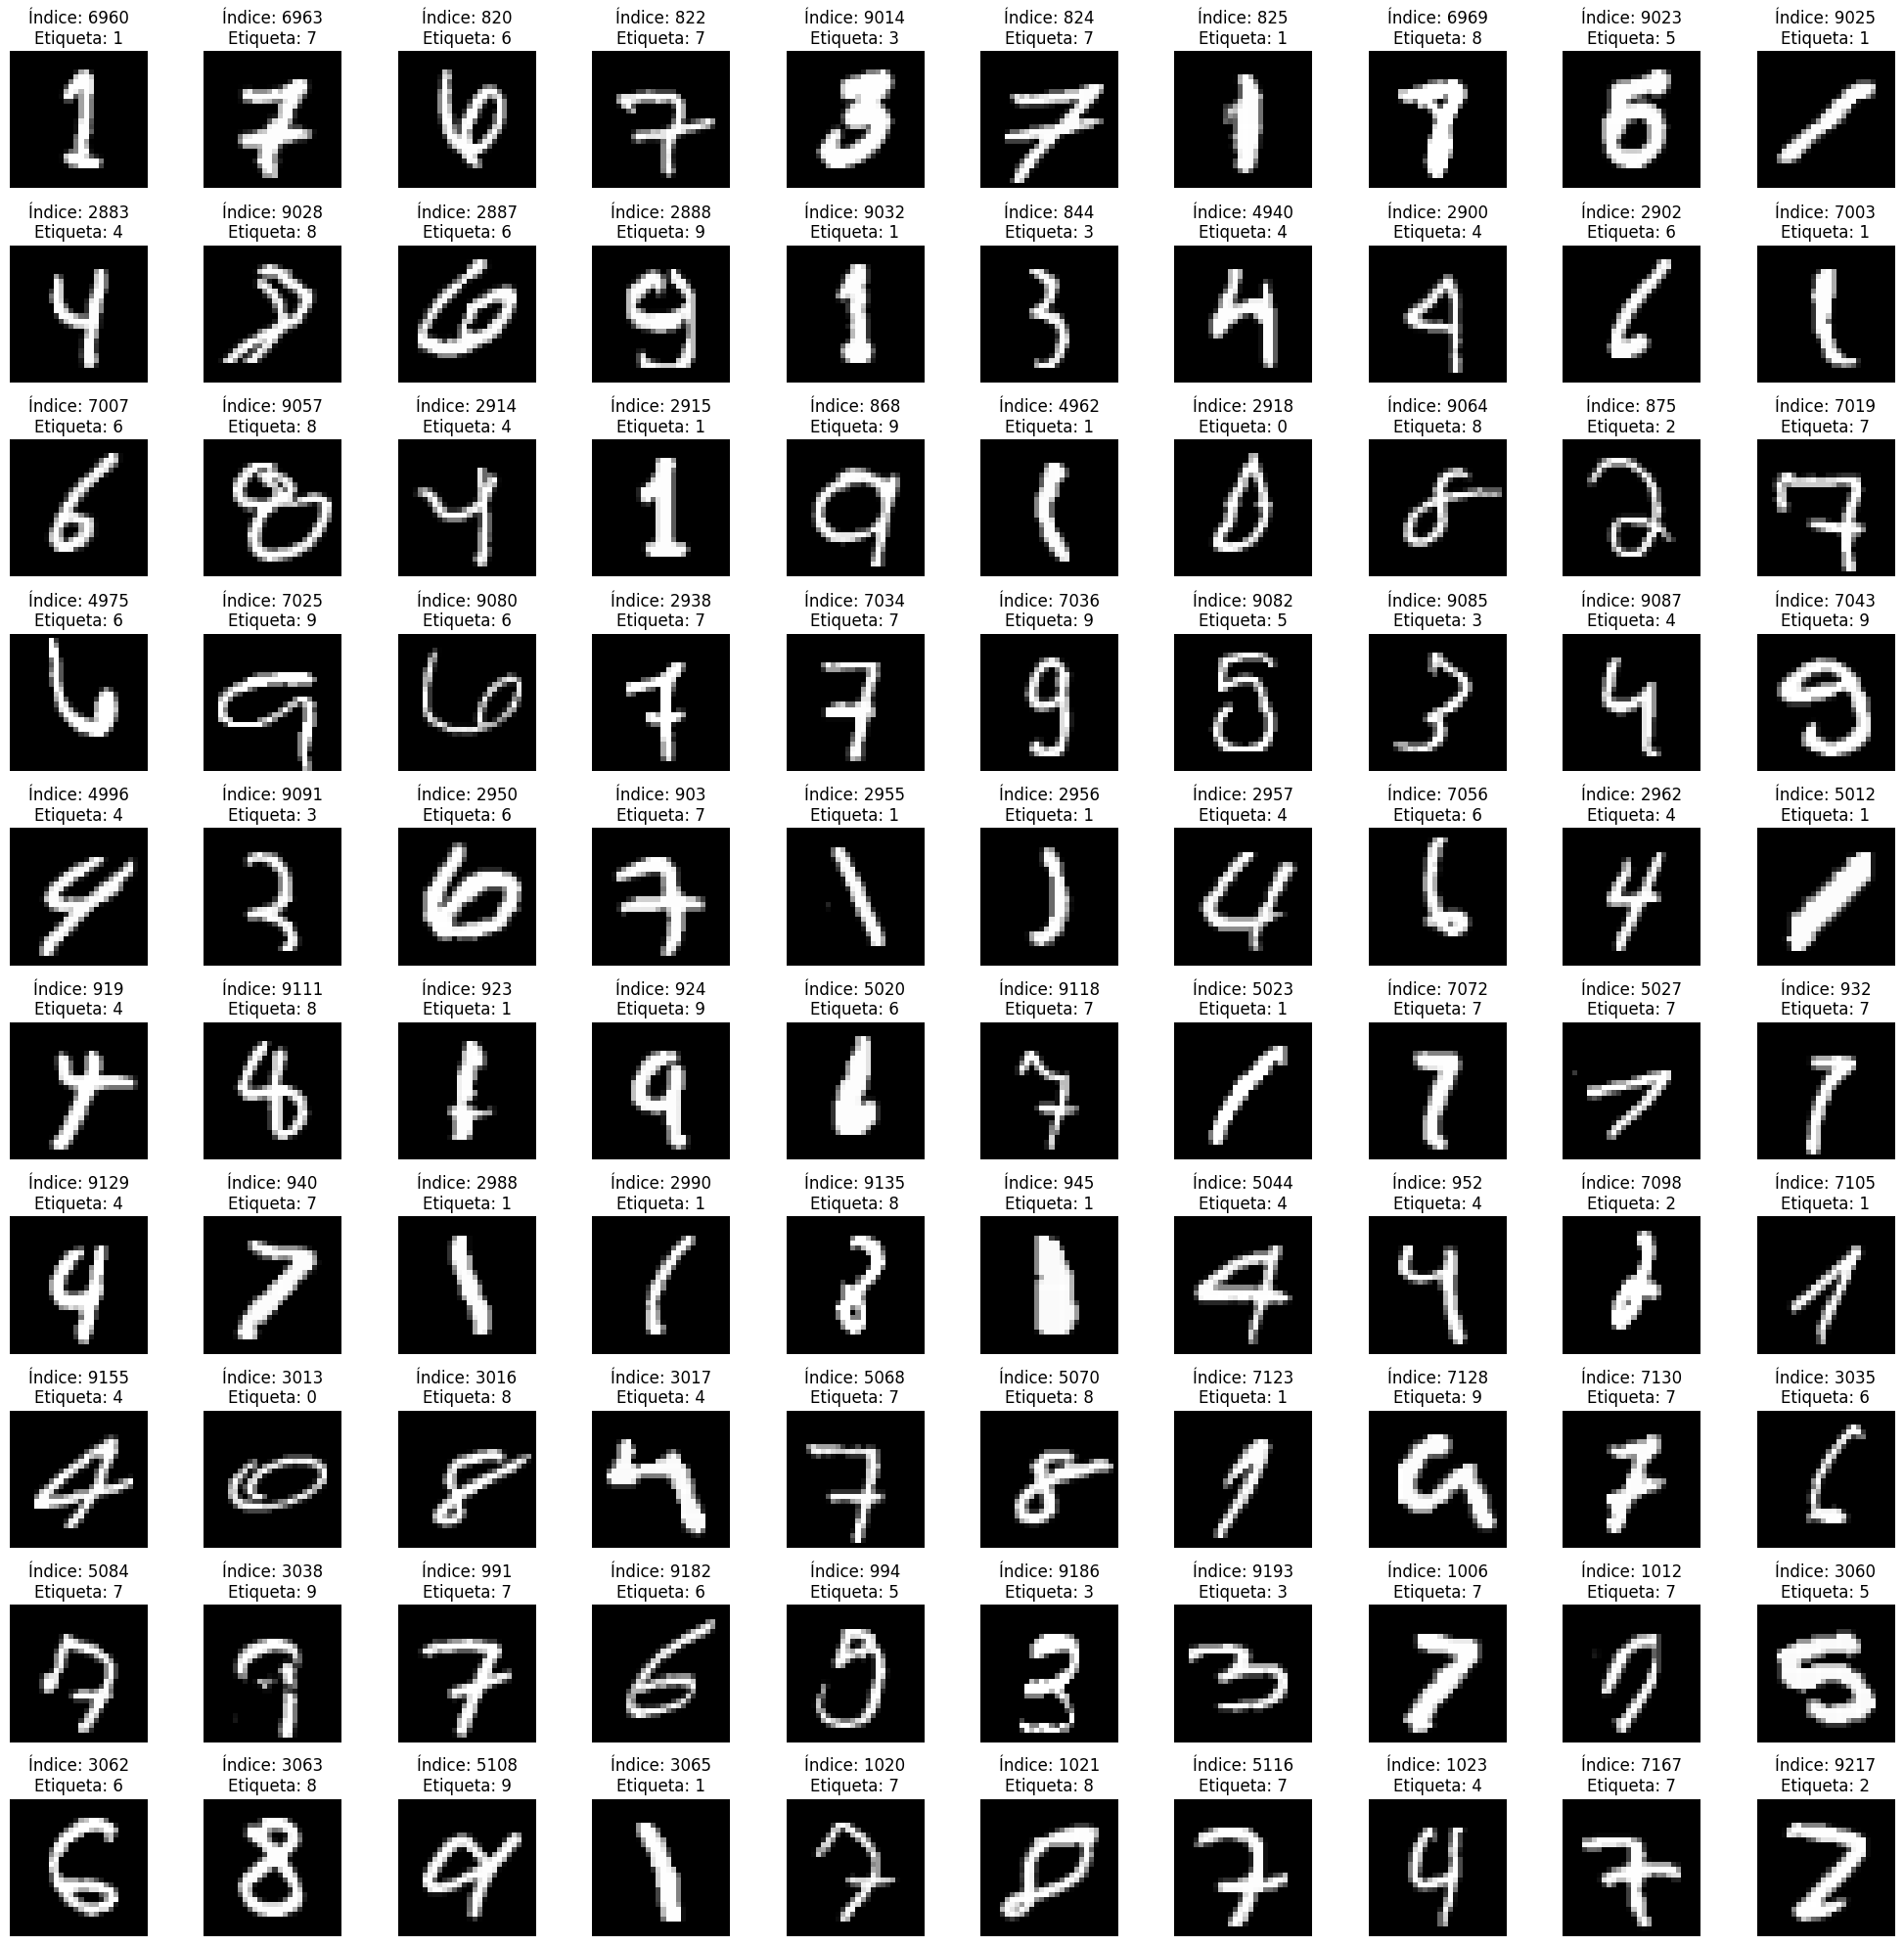

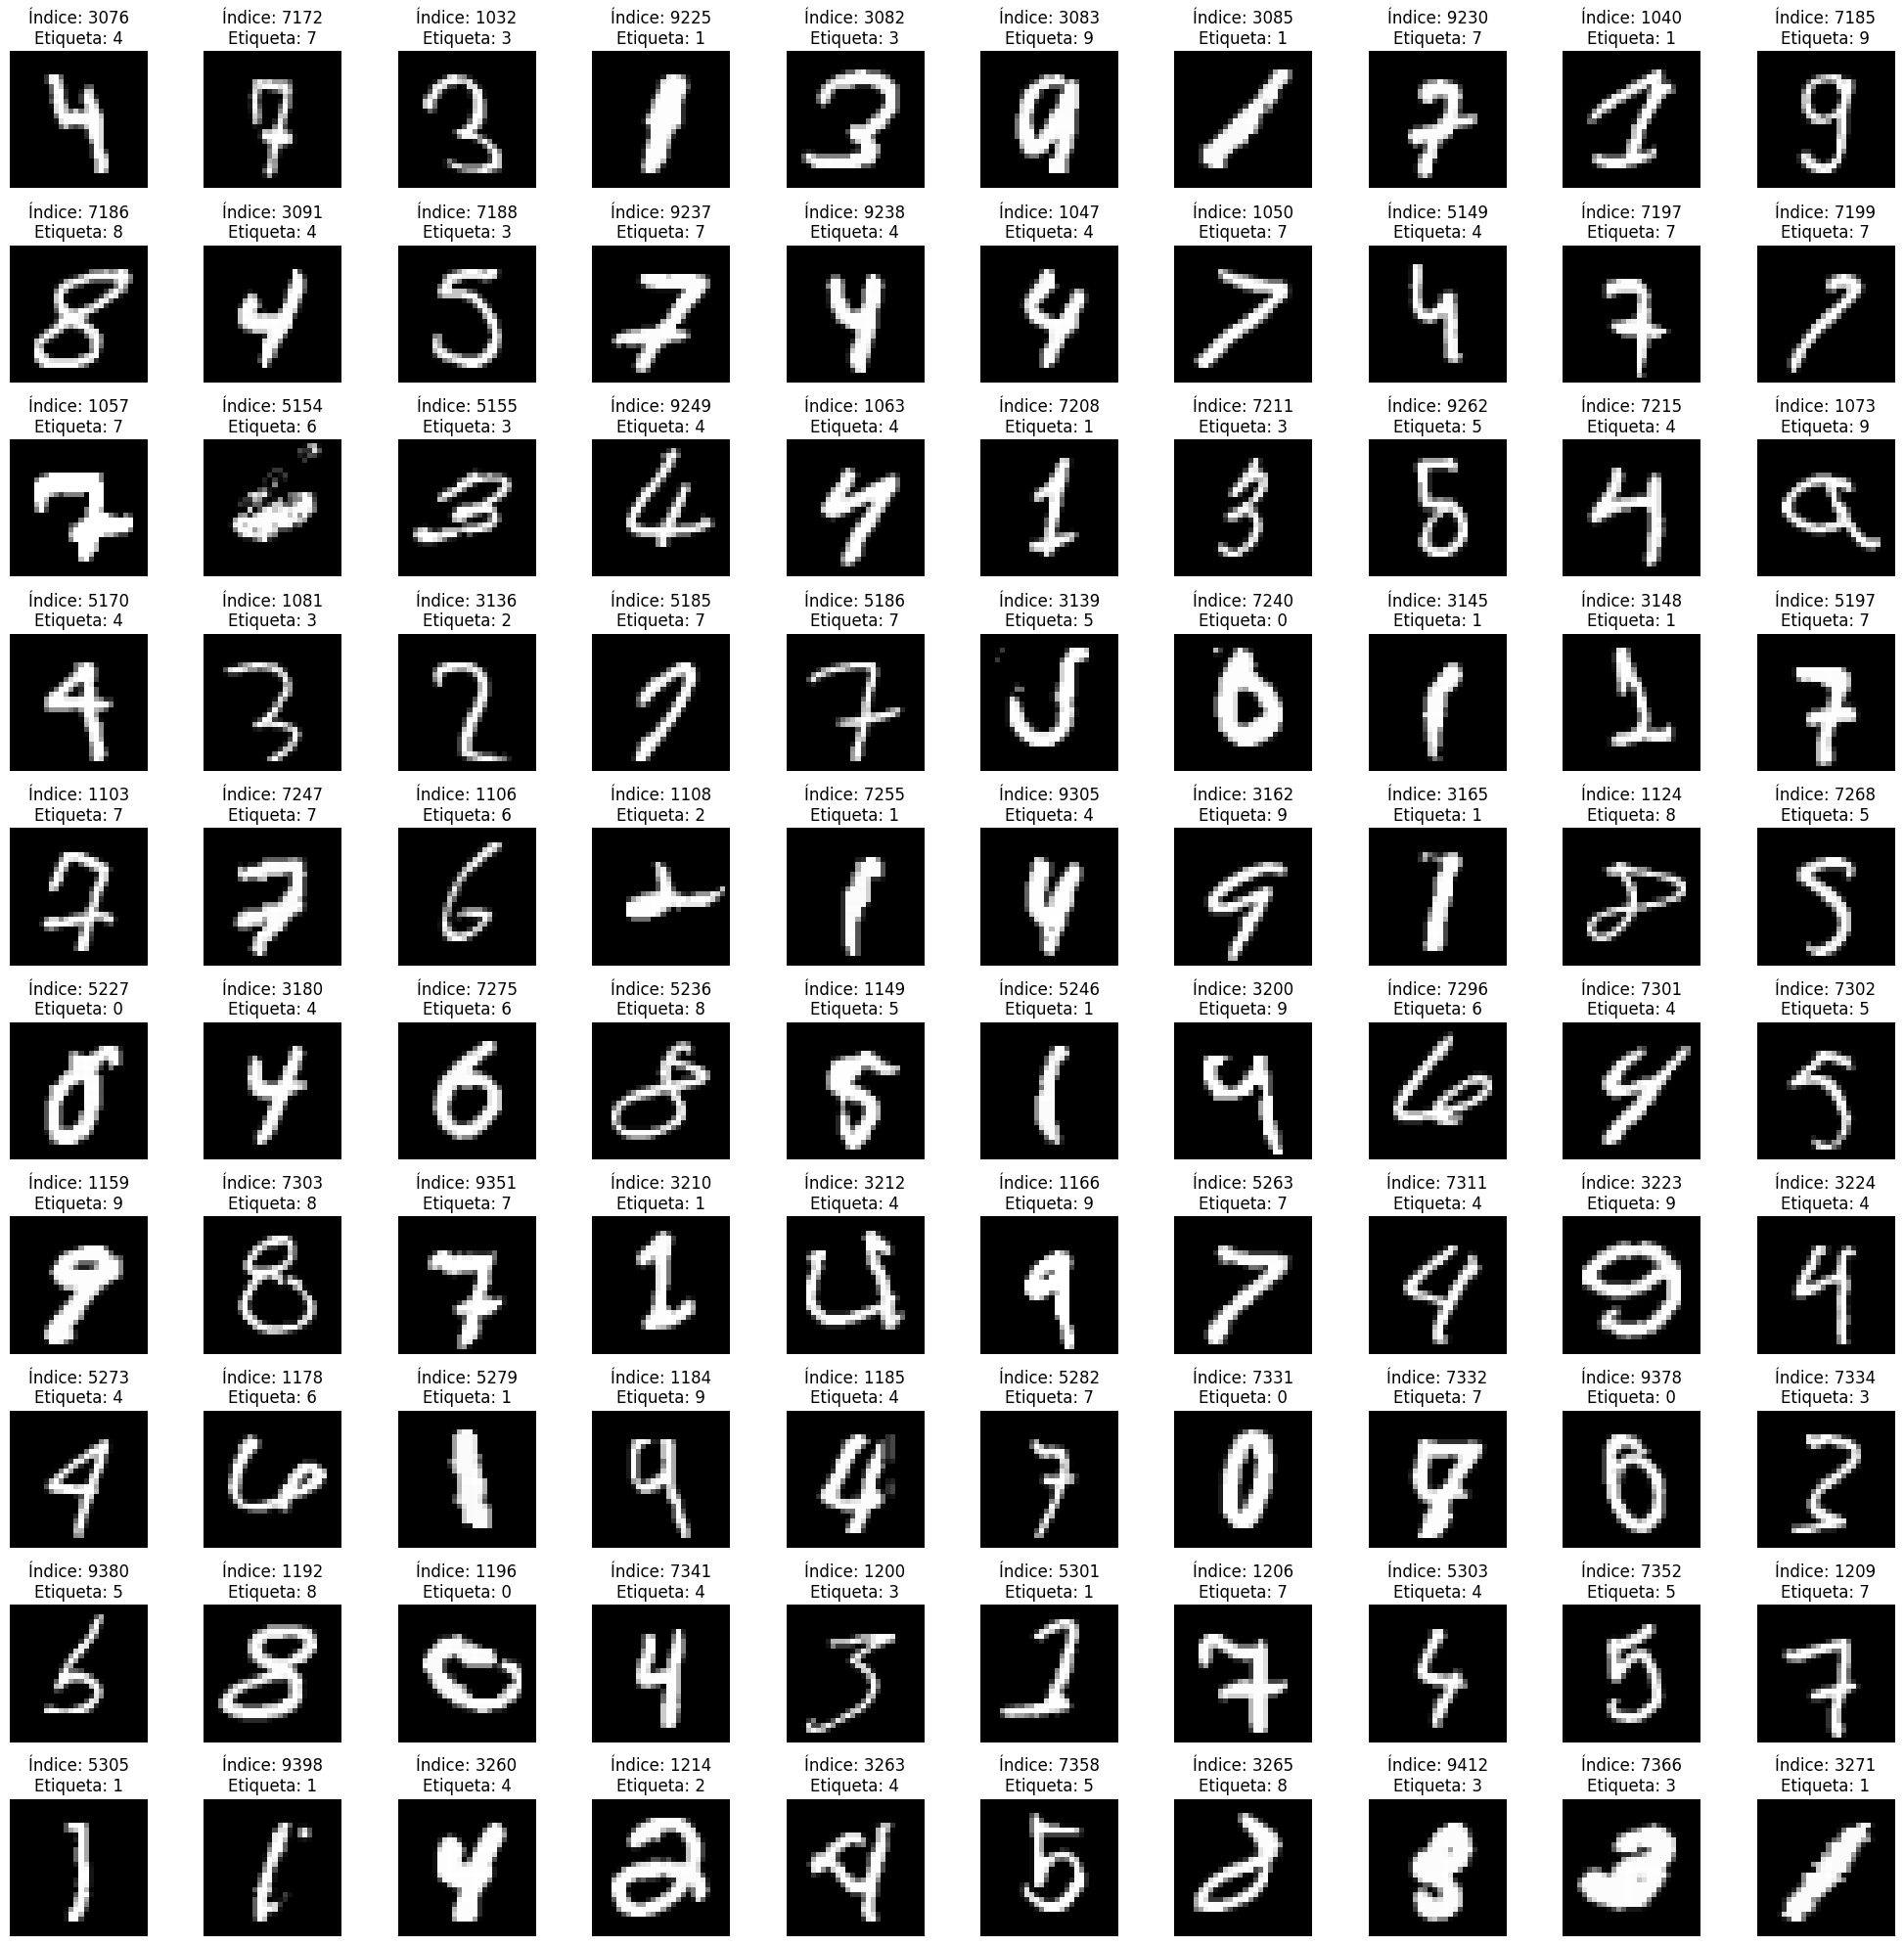

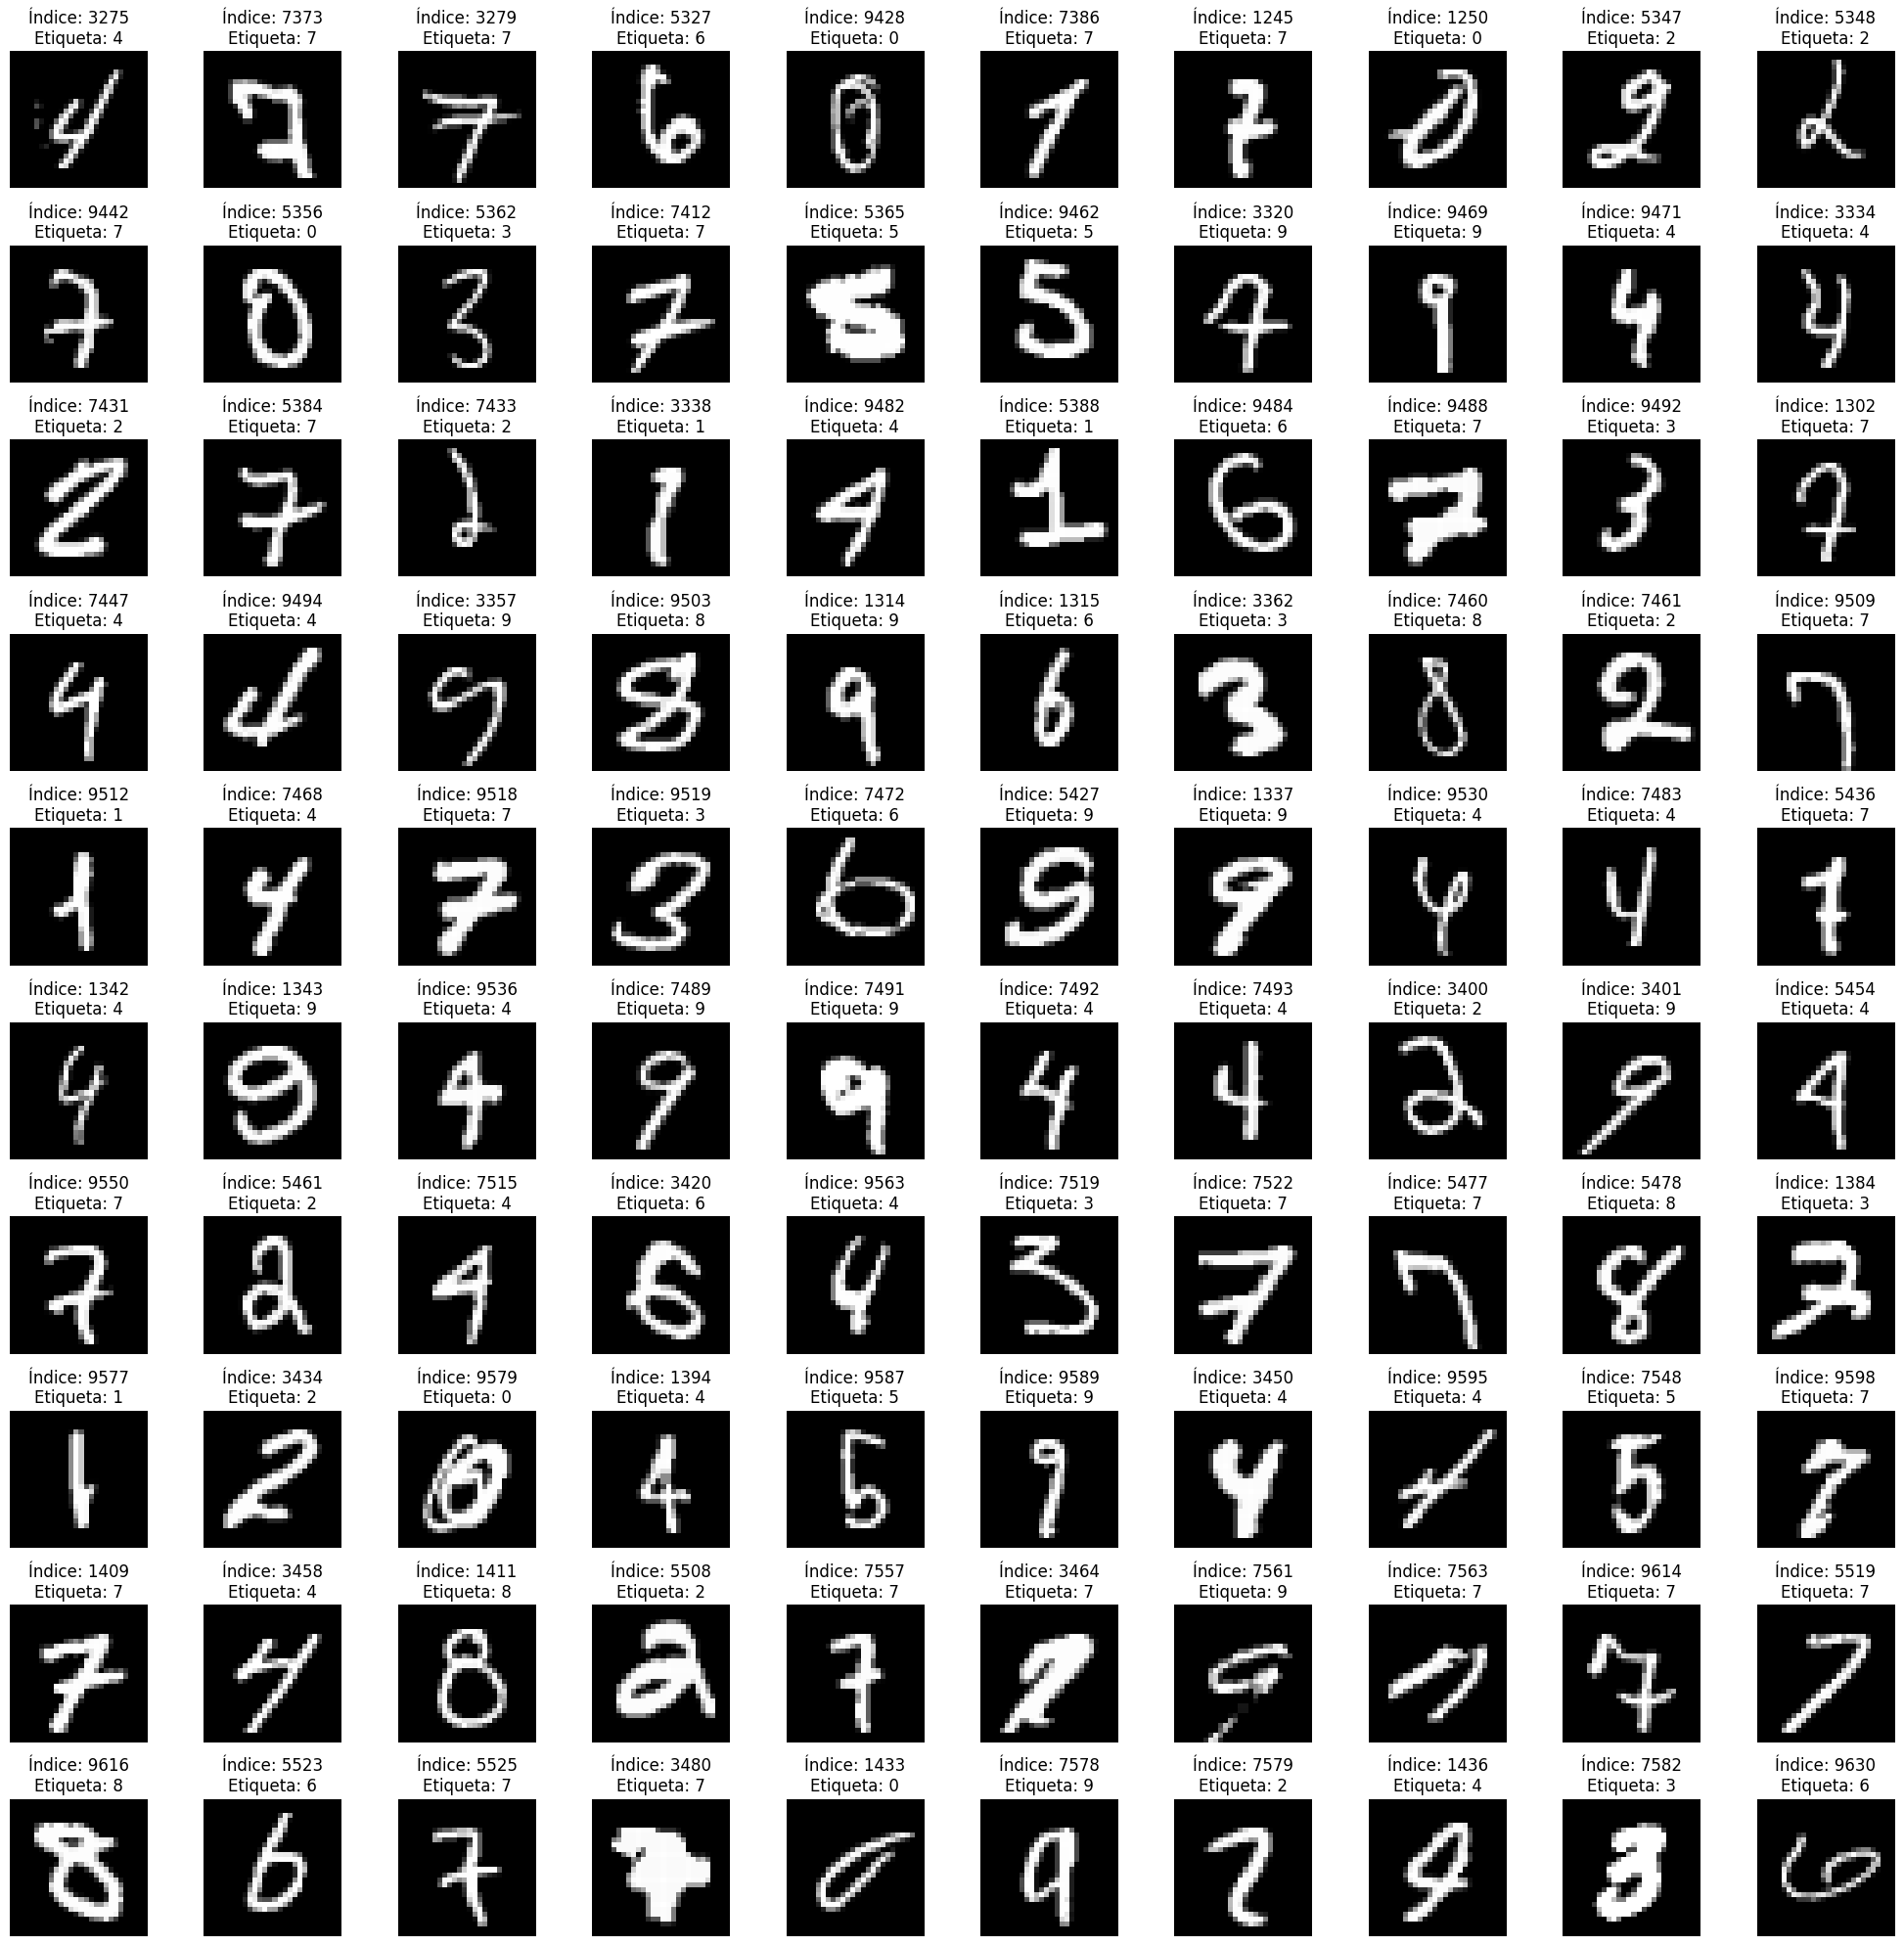

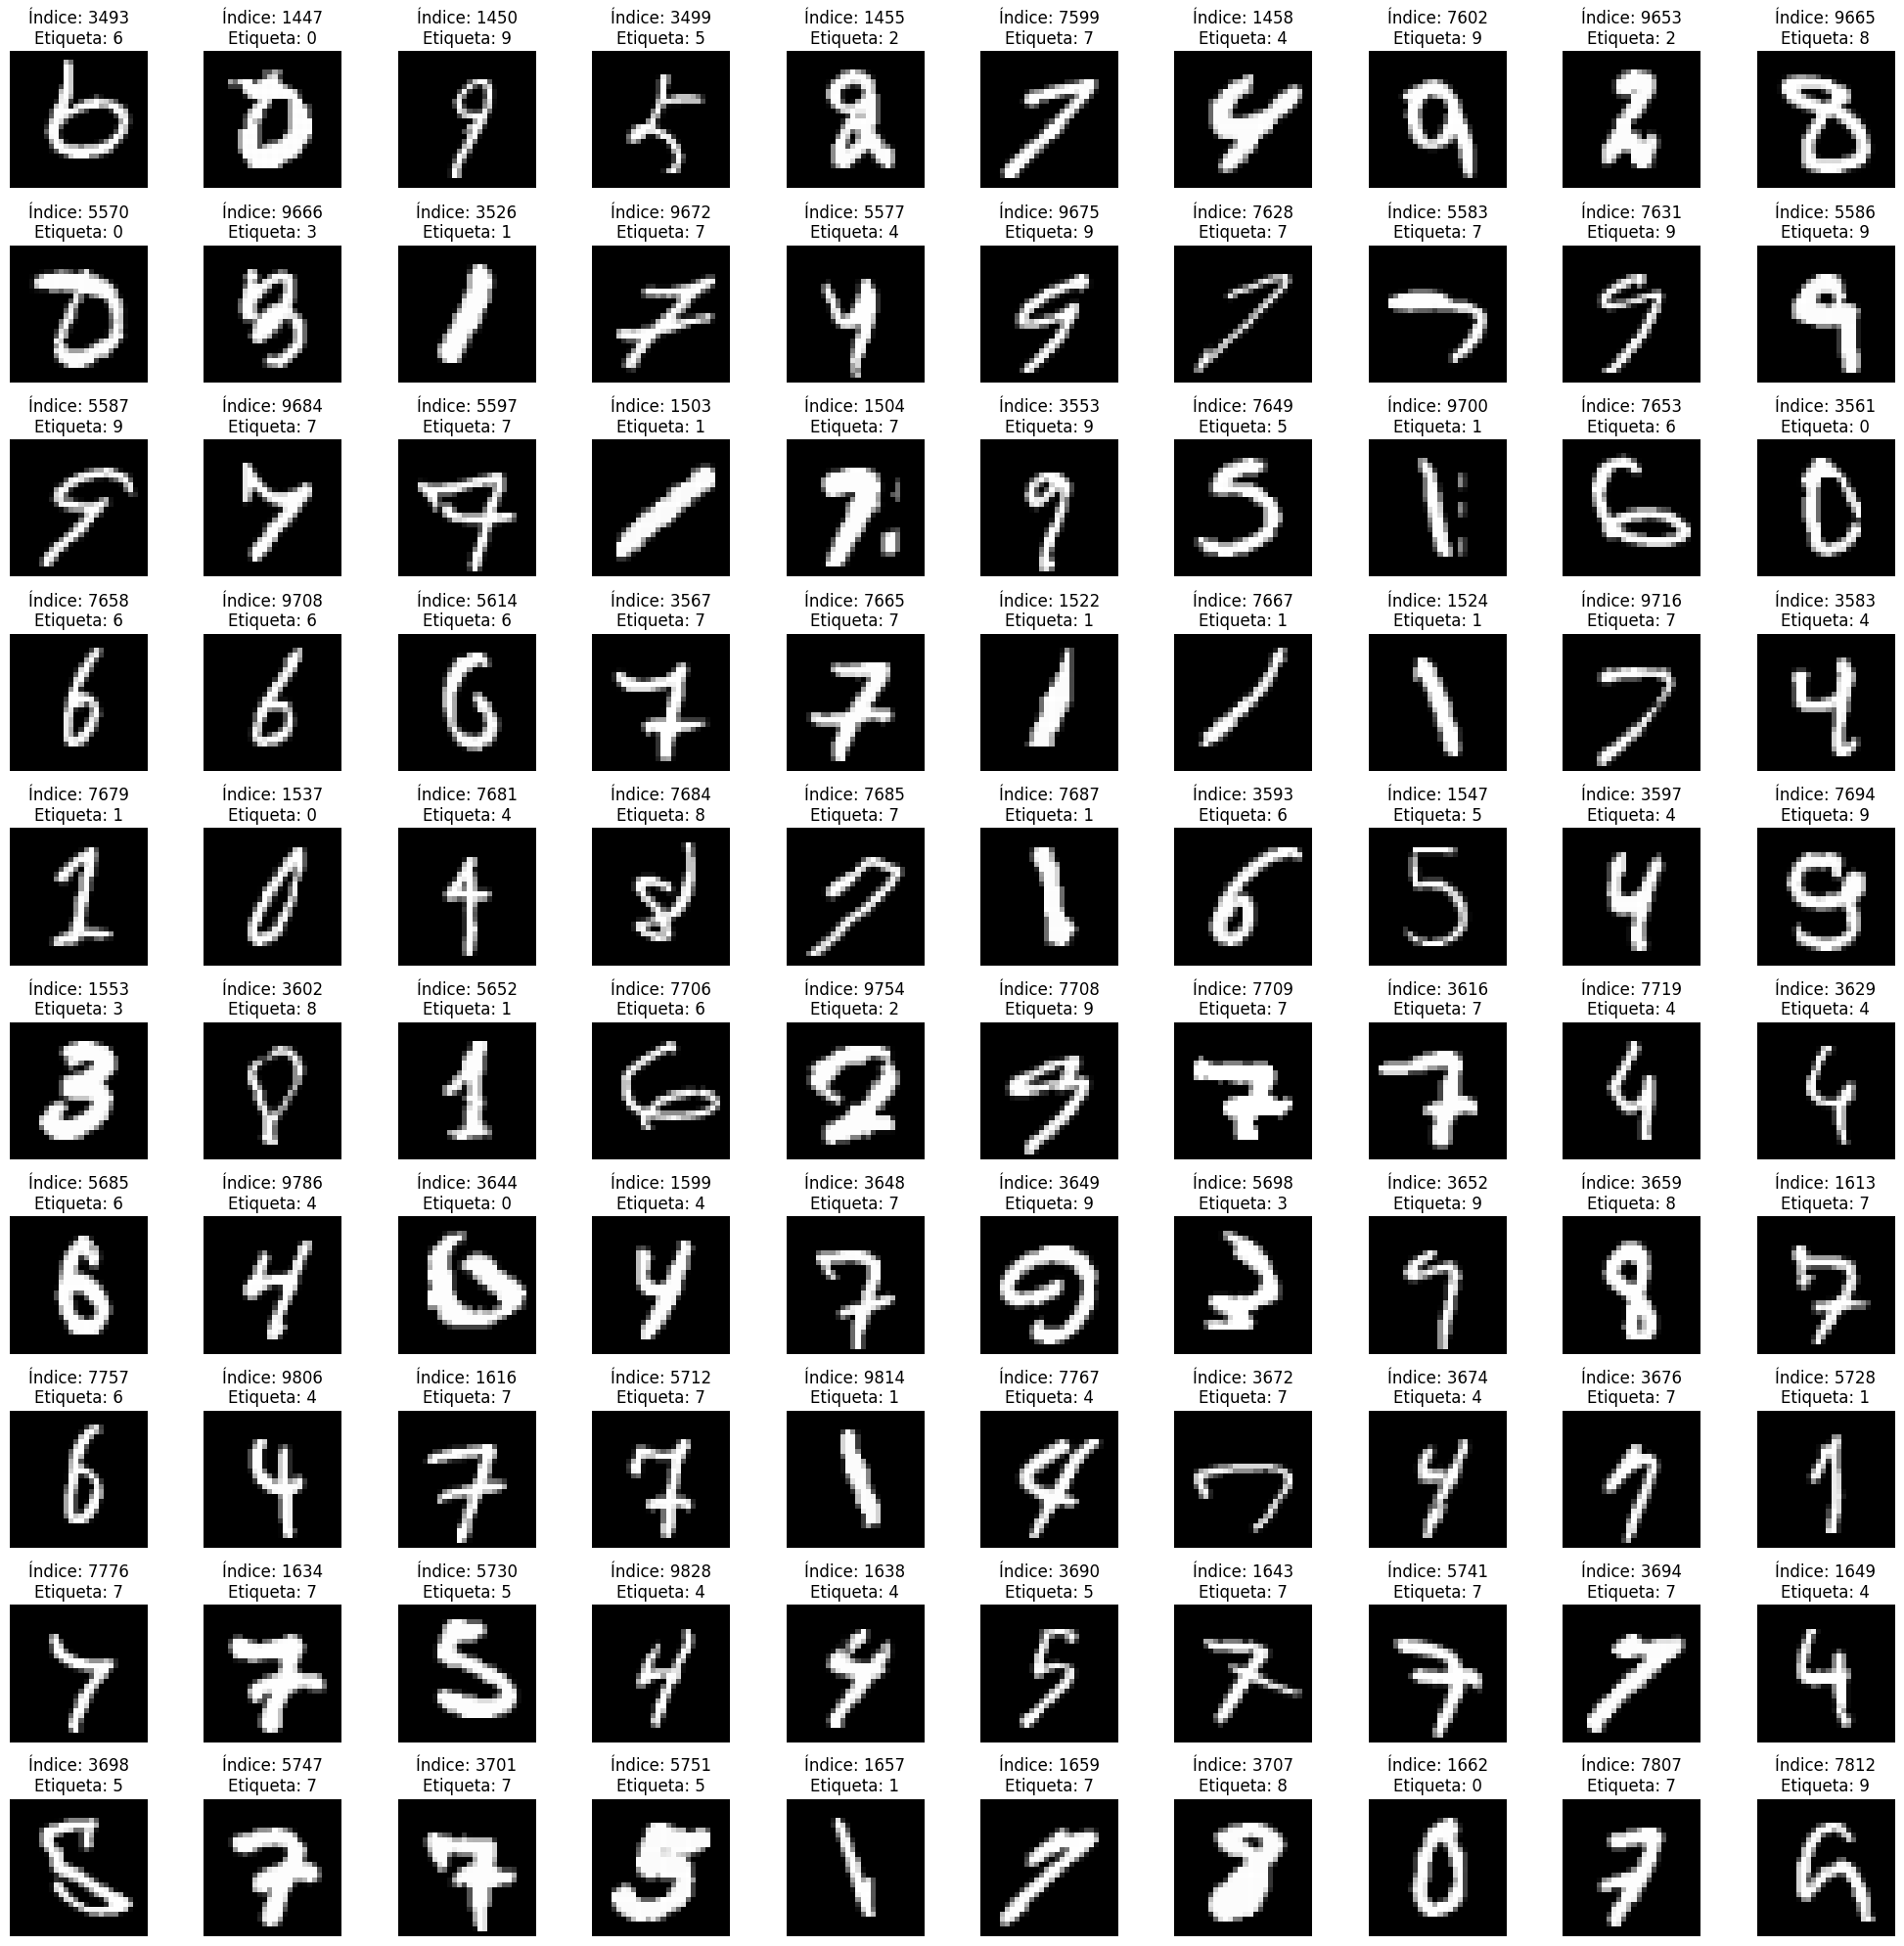

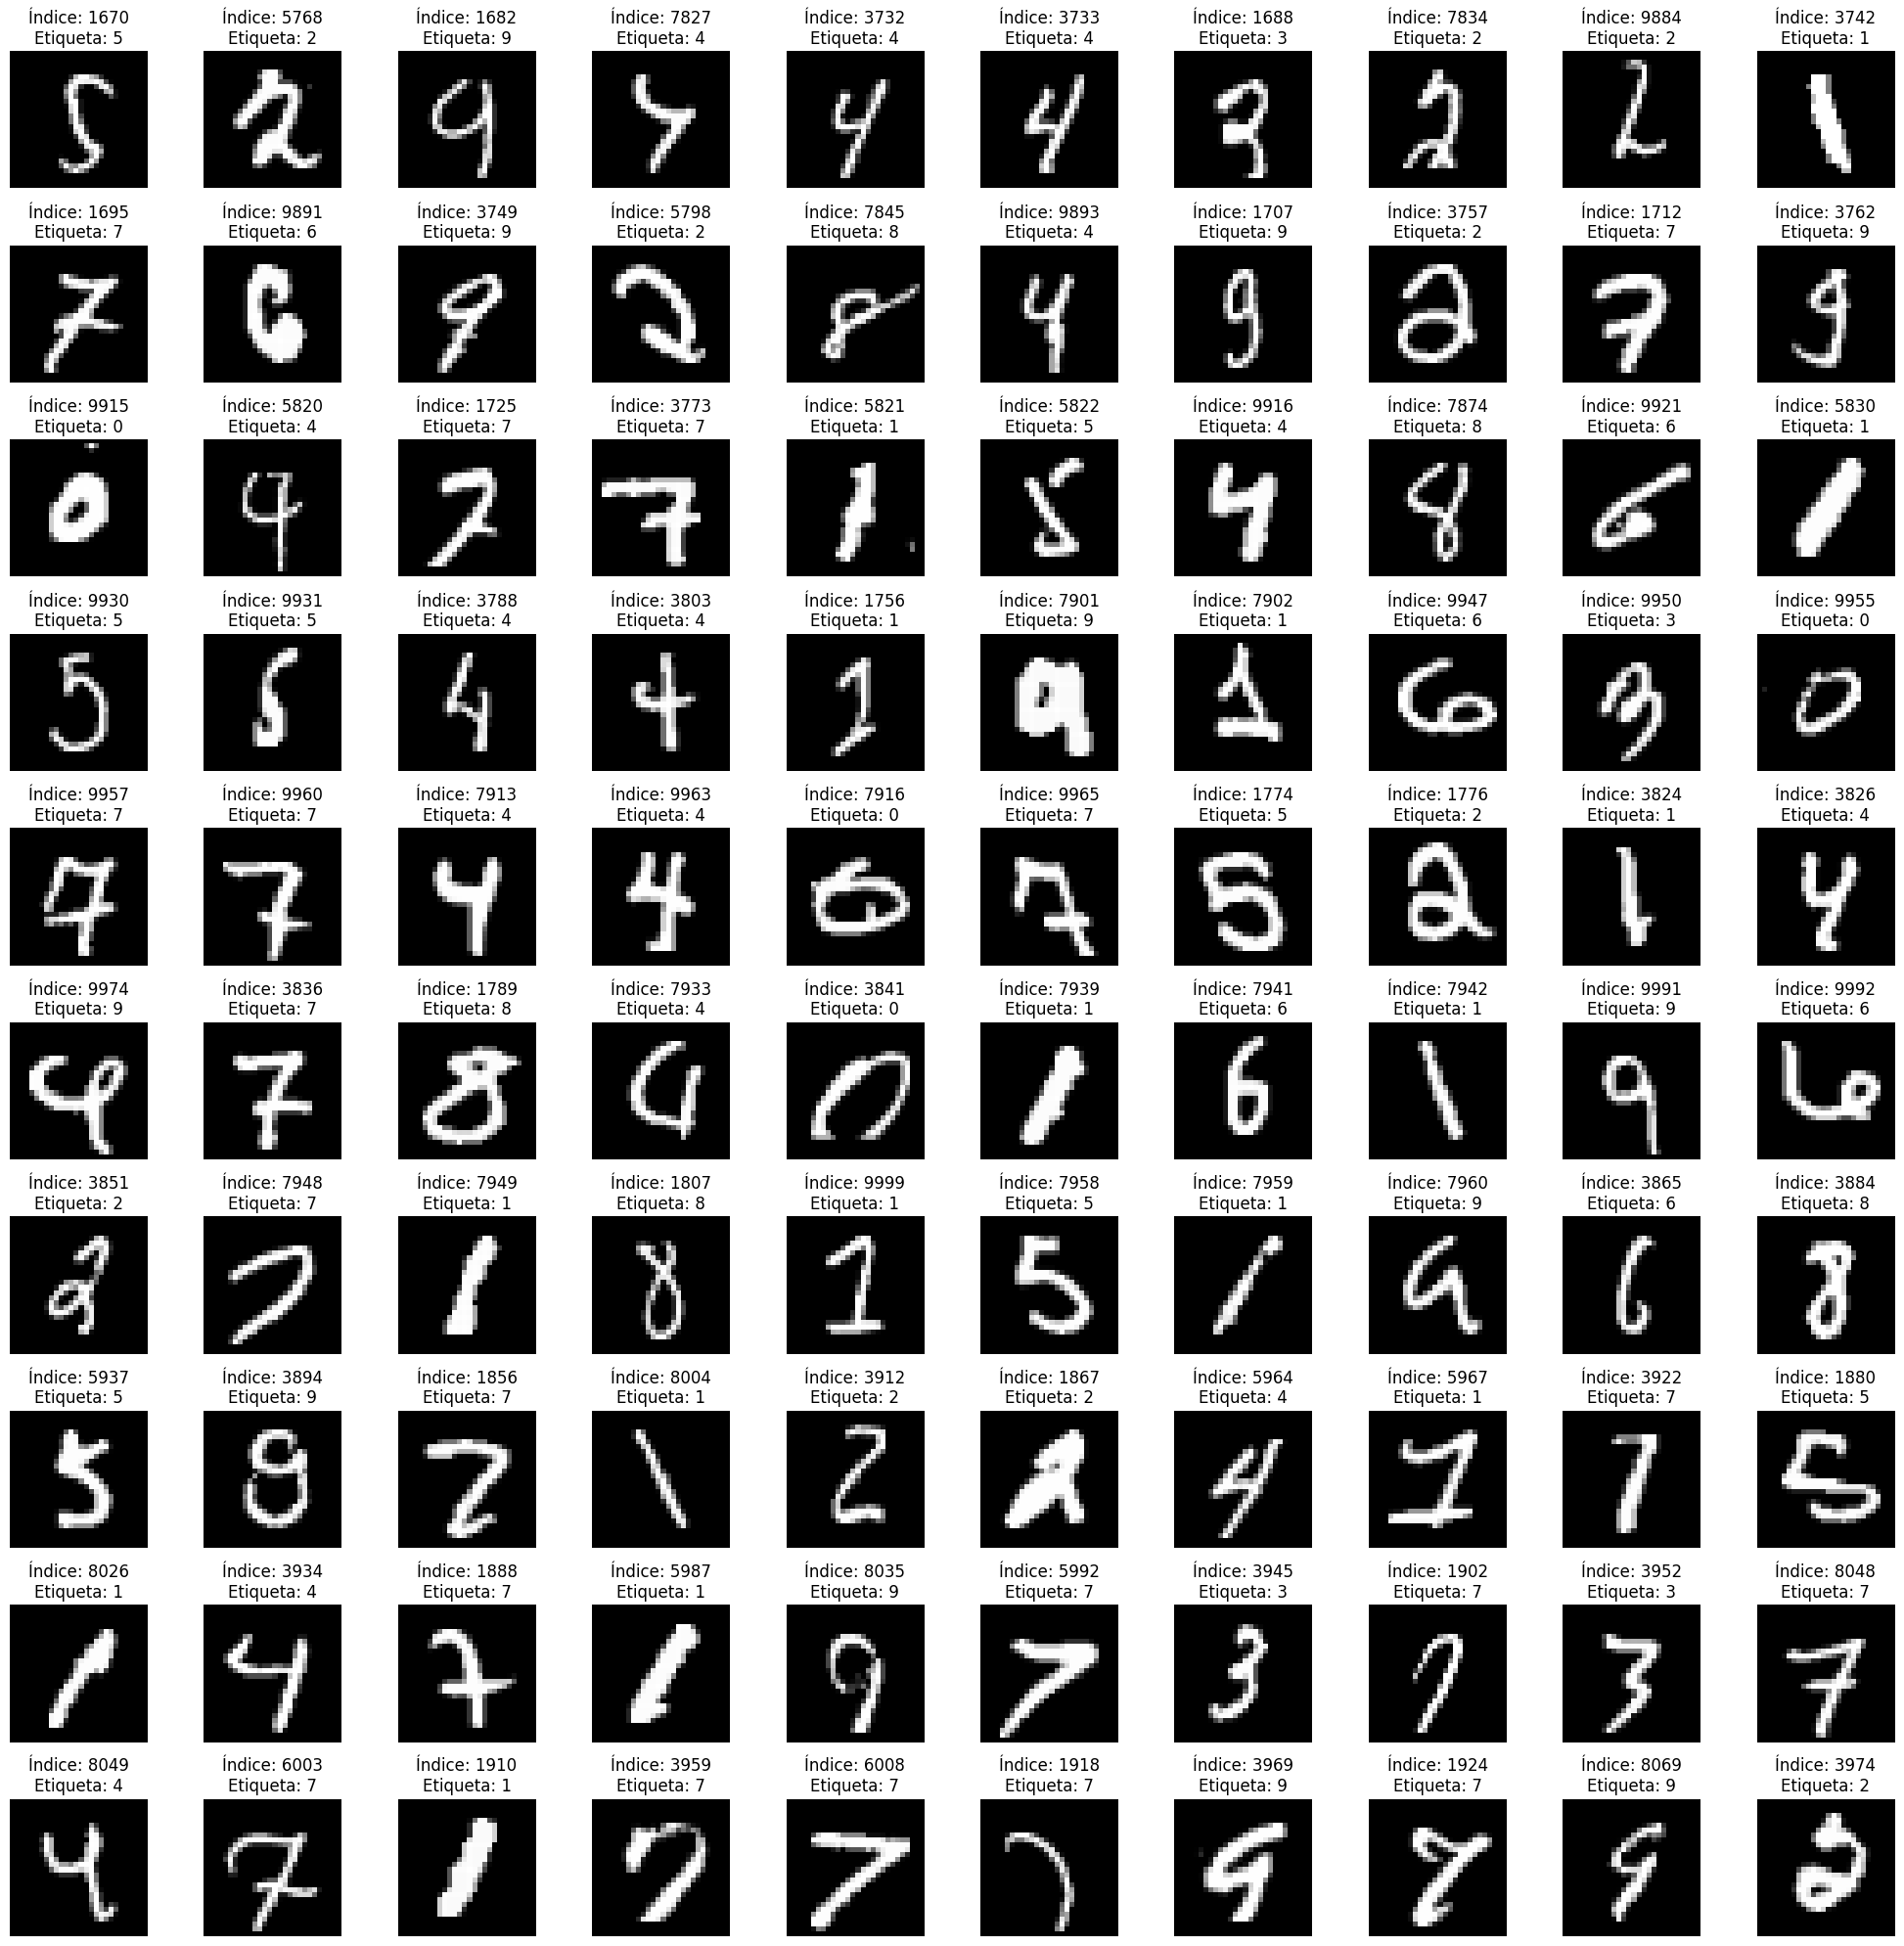

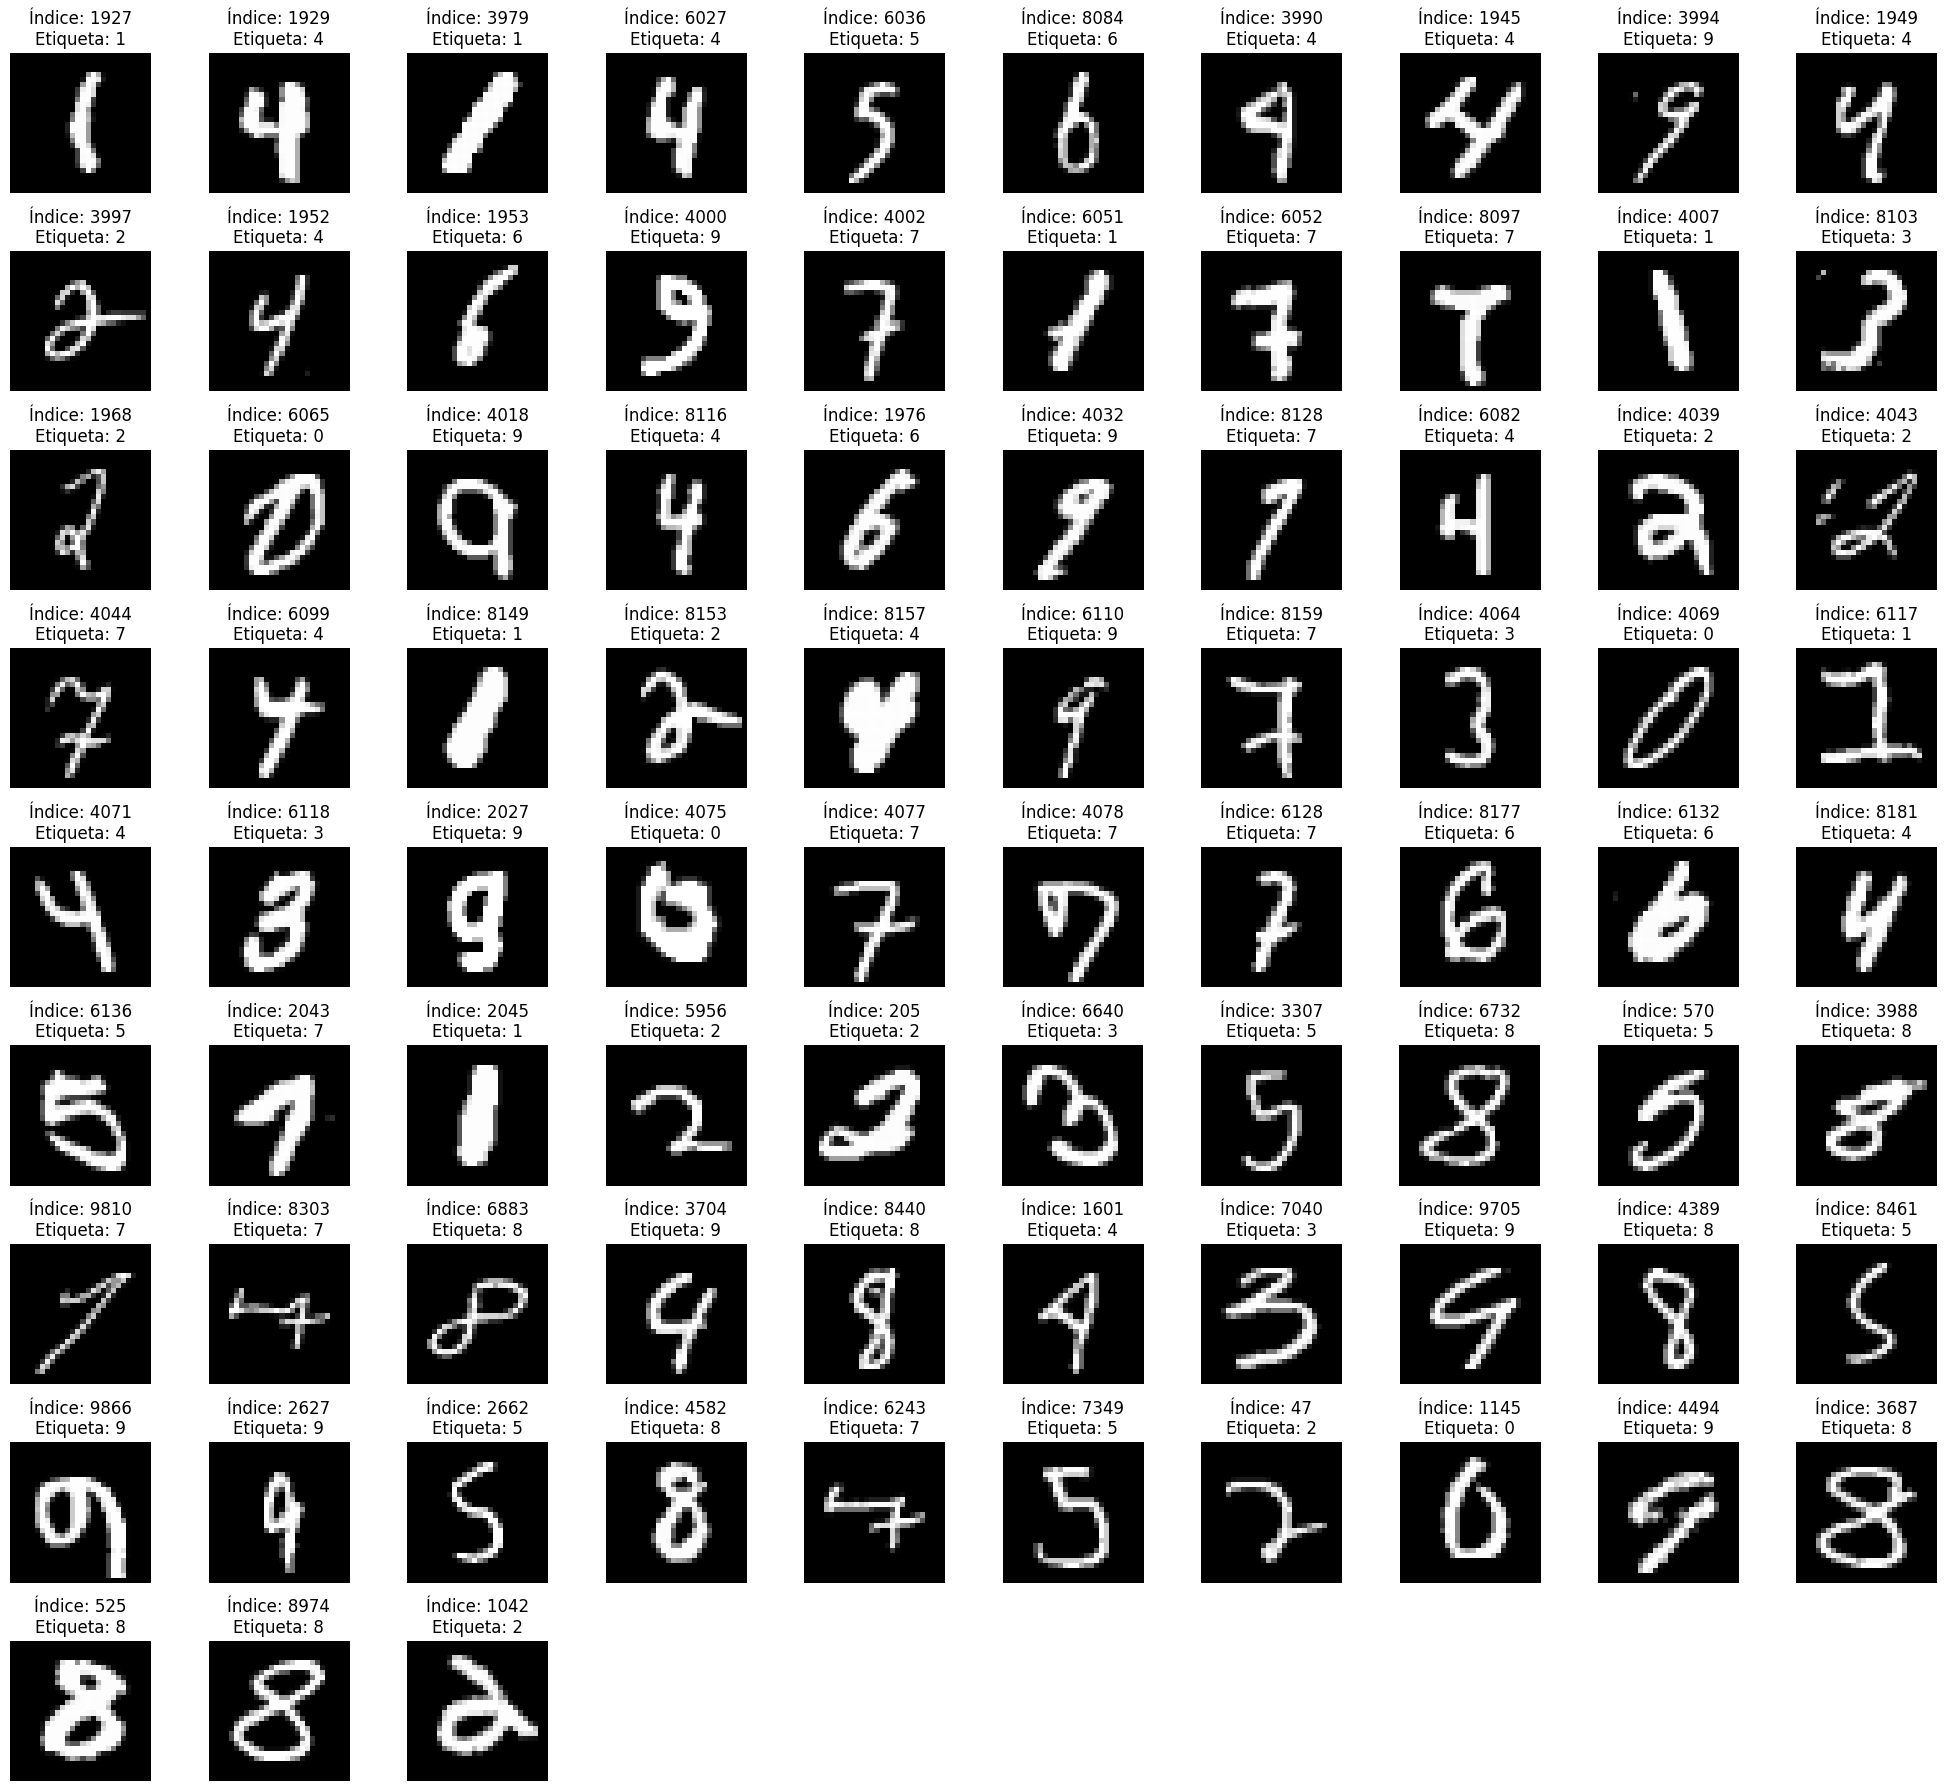

In [20]:
import math

num_images = len(data_removed)
grid_size = 10 

num_figures = math.ceil(num_images / (grid_size * grid_size))

for fig_num in range(num_figures):
    start_idx = fig_num * grid_size * grid_size
    end_idx = min(start_idx + grid_size * grid_size, num_images)
    
    plt.figure(figsize=(20, 20))
    for i, indice in enumerate(data_removed[start_idx:end_idx]):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(X_plot[indice].reshape(28, 28), cmap='gray')
        plt.title(f'Índice: {indice}\nEtiqueta: {y_plot[indice]}', fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


### Visualization with three PCA components

In [32]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 3 components for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(model_mnist.inspector_out(X_train))

# DataFrame with the transformed data and labels
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['class'] = y_train[random_indices_train]
df_pca['outlier'] = 'Normal'
df_pca.loc[data_removed, 'outlier'] = 'Outlier'

# Scatter plot of the original dataset
fig = px.scatter_3d(df_pca, x='PCA1', y='PCA2', z='PCA3', color='class',
                    title='PCA of MNIST',
                    labels={'class': 'Numbers'},
                    opacity=0.7)

# Highlight the points that were filtered (detected outliers)
fig.add_trace(go.Scatter3d(
    x=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA1'],
    y=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA2'],
    z=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA3'],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Outliers'
))

# Update the chart design
fig.update_layout(scene=dict(
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    zaxis_title='PCA Component 3'),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)

fig.show()